In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import plotly.express as px
import math
import statistics
import wbgapi as wb
import pycountry
import pycountry_convert as pc
import statsmodels.api as sm
import ipywidgets as widgets
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.weightstats import DescrStatsW
pd.options.plotting.backend = "plotly"

In [2]:
df_population = pd.read_csv("population_list.csv")

df_population_2020 = df_population[['Country Code', '2017', '2018', '2019']].copy()

#Calculate the mean population of each country in the period of 2017-2019
df_population_2020['population_2020_mean'] = df_population_2020[['2017', '2018', '2019']].mean(axis=1)

#Drop the rows without needed information
df_population_2020 = df_population_2020.dropna(subset=["population_2020_mean"])

df_population_2020 = df_population_2020.rename(columns={'Country Code': 'country_code'})

df_population_2020 = df_population_2020[["country_code", "population_2020_mean", "2017", "2018", "2019"]]

df_population_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265 entries, 0 to 265
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country_code          265 non-null    object 
 1   population_2020_mean  265 non-null    float64
 2   2017                  265 non-null    float64
 3   2018                  265 non-null    float64
 4   2019                  265 non-null    float64
dtypes: float64(4), object(1)
memory usage: 12.4+ KB


Prepare country GDP per capita information

In [3]:
df_gdp_per_capita = pd.read_csv("gdp_per_capita.csv")

df_gdp_2020 = df_gdp_per_capita[['Country Code', '2017', '2018', '2019']].copy()

df_gdp_2020 = df_gdp_2020.dropna()

#Calculate the mean GDP per capita of each country in the period of 2017-2019
df_gdp_2020['gdp_2020_mean'] = df_gdp_2020[['2017', '2018', '2019']].mean(axis=1)

df_gdp_2020.rename(columns={'Country Code': 'country_code'}, inplace=True)

#Drop the rows without needed information
df_gdp_2020.dropna(subset=["2019"], inplace=True)

#Calculate the log mean of GDP per capita as with previous studies
df_gdp_2020['gdp_2020_log'] = np.log(df_gdp_2020['gdp_2020_mean'])

df_gdp_2020 = df_gdp_2020[["country_code", "gdp_2020_mean", "gdp_2020_log", "2017", "2018", "2019"]]

df_gdp_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 258 entries, 0 to 265
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_code   258 non-null    object 
 1   gdp_2020_mean  258 non-null    float64
 2   gdp_2020_log   258 non-null    float64
 3   2017           258 non-null    float64
 4   2018           258 non-null    float64
 5   2019           258 non-null    float64
dtypes: float64(5), object(1)
memory usage: 14.1+ KB


Prepare country life expectancy at birth information

In [4]:
df_life_expectancy = pd.read_csv("life_expectancy.csv")

df_le_2020 = df_life_expectancy[['Country Code', '2017', '2018', '2019']].copy()

#Calculate the 2017-2019 mean life expectancy at birth by each country
df_le_2020['le_2020_mean'] = df_le_2020[['2017', '2018', '2019']].mean(axis=1)

#Drop the rows without needed information
df_le_2020 = df_le_2020.dropna(subset=["le_2020_mean"])

df_le_2020 = df_le_2020.rename(columns={'Country Code': 'country_code'})

df_le_2020 = df_le_2020[["country_code", "le_2020_mean", "2017", "2018", "2019"]]

df_le_2020.info()

#Save the dataframe for further processing
df_le_2020.to_csv('le_2020.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 258 entries, 0 to 265
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  258 non-null    object 
 1   le_2020_mean  258 non-null    float64
 2   2017          258 non-null    float64
 3   2018          257 non-null    float64
 4   2019          257 non-null    float64
dtypes: float64(4), object(1)
memory usage: 12.1+ KB


Perpare country income group information

In [5]:
#Get information of country income groups from the web
table = wb.economy.info(db=66)

table_dict = vars(table)
df_income_group_temp = pd.DataFrame(table_dict.get('items'))
df_income_group = df_income_group_temp[['id', 'incomeLevel']].copy()

#Delete all rows without sufficient information
df_income_group = df_income_group.dropna(subset=["incomeLevel"])

df_income_group.rename(columns={'id': 'country_code', 'incomeLevel': 'income_level'}, inplace=True)

df_income_group.info()

df_income_group.to_csv('income_level.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, 0 to 169
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country_code  169 non-null    object
 1   income_level  169 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB


Prepare the main dataframe for further analysis

In [6]:
#Read the primary database
df_main = pd.read_csv("primary_db_2020.csv")
print("The Primary dataset:")
df_main.info()
print("")

df_main.rename(columns={'Country name': 'country', 'Regional indicator': 'region', 'Ladder score': 'happiness_score', 'Social support': 'social_support', 'Freedom to make life choices': 'freedom_to_make_life_choices', 'Generosity': 'generosity', 'Perceptions of corruption': 'perceptions_of_corruption'}, inplace=True)

#Drop all unneeded columns
df_main = df_main.drop(['Standard error of ladder score', 'upperwhisker', 'lowerwhisker', 'Logged GDP per capita', 'Healthy life expectancy', 'Ladder score in Dystopia', 'Explained by: Log GDP per capita', 'Explained by: Social support', 'Explained by: Healthy life expectancy', 'Explained by: Freedom to make life choices', 'Explained by: Generosity', 'Explained by: Perceptions of corruption', 'Dystopia + residual'], axis=1)

#Add ISO-alpha3 counry codes to the man dataframe
def country_name_to_code(country_name):
    try:
        country = pycountry.countries.get(name=country_name)
        if country:
            return country.alpha_3
        else:
            return None
    except KeyError:
        return None

df_main['country_code'] = df_main['country'].apply(country_name_to_code)

#Centralize all needed country infomation
df_main_temp1 = df_main.merge(df_population_2020, on='country_code', how='left')
df_main_temp1 = df_main_temp1.drop(['2017', '2018', '2019'], axis=1)

df_main_temp2 = df_main_temp1.merge(df_gdp_2020, on='country_code', how='left')
df_main_temp2 = df_main_temp2.drop(['2017', '2018', '2019'], axis=1)

df_main_temp3 = df_main_temp2.merge(df_le_2020, on='country_code', how='left')
df_main_temp3 = df_main_temp3.drop(['2017', '2018', '2019'], axis=1)

df_main_temp4 = df_main_temp3.merge(df_income_group, on='country_code', how='left')

print("Scenario with countries' missing data")
df_main_temp4.info()
print("")

df_new_countries = pd.read_csv("new_countries.csv")

#Concatnate the countries' infomation with missing data
df_main_temp4= pd.concat([df_main_temp4, df_new_countries], ignore_index=True)

df_main_renewed = df_main_temp4.dropna()

#Recoder all needed information
df_main_renewed = df_main_renewed[["country_code", "country", "region", "income_level", "population_2020_mean", "happiness_score", "gdp_2020_mean", "gdp_2020_log", "le_2020_mean", 
    "social_support", "freedom_to_make_life_choices", "generosity", "perceptions_of_corruption"]]

#Sort all information by descending order of happiness score
df_main_renewed = df_main_renewed.sort_values(by=['happiness_score'], ascending=False)

print("Scenario with countries with all data filled")
df_main_renewed.info()

The Primary dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 20 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Country name                                153 non-null    object 
 1   Regional indicator                          153 non-null    object 
 2   Ladder score                                153 non-null    float64
 3   Standard error of ladder score              153 non-null    float64
 4   upperwhisker                                153 non-null    float64
 5   lowerwhisker                                153 non-null    float64
 6   Logged GDP per capita                       153 non-null    float64
 7   Social support                              153 non-null    float64
 8   Healthy life expectancy                     153 non-null    float64
 9   Freedom to make life choices                153 non-null    float6

Calculate mean national sample total population over the world's total population

In [7]:
'''
As per United Nations Report, the world's total population in
2017: 7645617954
2018: 7645617954
2019: 7811293698
'''

record_total_population_2020 = (7645617954 + 7729902781 + 7811293698) / 3 #Mean Total: 7728938144

data_total_population_2020 = df_main_renewed['population_2020_mean'].sum()

percent_of_pop_in_study = (data_total_population_2020 / record_total_population_2020) * 100

#Calculate the population weighting for the covering countires
df_main_renewed["country_weight"] = df_main_renewed["population_2020_mean"] / record_total_population_2020

df_main_renewed.info()
print("")

print(f"The population covered in this study (mean as of years 2017-2019): {int(data_total_population_2020)}, which accounts for {percent_of_pop_in_study:.2f}% of the world's population ({int(record_total_population_2020)}).")

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 0 to 152
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country_code                  153 non-null    object 
 1   country                       153 non-null    object 
 2   region                        153 non-null    object 
 3   income_level                  153 non-null    object 
 4   population_2020_mean          153 non-null    float64
 5   happiness_score               153 non-null    float64
 6   gdp_2020_mean                 153 non-null    float64
 7   gdp_2020_log                  153 non-null    float64
 8   le_2020_mean                  153 non-null    float64
 9   social_support                153 non-null    float64
 10  freedom_to_make_life_choices  153 non-null    float64
 11  generosity                    153 non-null    float64
 12  perceptions_of_corruption     153 non-null    float64
 13  country_we

In [8]:
#Save the dataframe for further processing
df_main_renewed.to_csv('renewed_db_2020.csv')

In [9]:
df_main_renewed_2 = df_main_renewed.drop(['population_2020_mean', 'country_weight'], axis=1)

#Save the dataframe for OLS regression
df_main_renewed_2.to_csv('renewed_db_2020_ols_regression.csv')

Overall Weighted statistics in the study

In [10]:
w=df_main_renewed['country_weight']

#Calculate the weighted means of the happiness score and the the 6 indicators in the study
w_happiness_score = DescrStatsW(df_main_renewed['happiness_score'], weights=w)
w_gdp_2020_mean = DescrStatsW(df_main_renewed['gdp_2020_mean'], weights=w)
w_gdp_2020_log = DescrStatsW(df_main_renewed['gdp_2020_log'], weights=w)
w_le_2020_mean = DescrStatsW(df_main_renewed['le_2020_mean'], weights=w)
w_social_support = DescrStatsW(df_main_renewed['social_support'], weights=w)
w_freedom_to_make_life_choices = DescrStatsW(df_main_renewed['freedom_to_make_life_choices'], weights=w)
w_generosity = DescrStatsW(df_main_renewed['generosity'], weights=w)
w_perceptions_of_corruption = DescrStatsW(df_main_renewed['perceptions_of_corruption'], weights=w)

print("Weighted means (2017-2019) in the study:")
print(f"Ladder (Happiness) Score (0-10) - {w_happiness_score.mean:.2f}")
print(f"GDP per capita (in current US$) - {w_gdp_2020_mean.mean:.4f}")
print(f"Log(GDP per capita) - {w_gdp_2020_log.mean:.4f}")
print(f"Life Expectancy at Birth - {w_le_2020_mean.mean:.2f}")
print(f"Social Support (0-1) - {w_social_support.mean:.4f}")
print(f"Freedom to Make Life Choices (0-1) - {w_freedom_to_make_life_choices.mean:.4f}")
print(f"Generosity - {w_generosity.mean:.4f}")
print(f"Perceptions of Corruption (0-1) - {w_perceptions_of_corruption.mean:.4f}")

Weighted means (2017-2019) in the study:
Ladder (Happiness) Score (0-10) - 5.08
GDP per capita (in current US$) - 11455.8890
Log(GDP per capita) - 8.5655
Life Expectancy at Birth - 72.86
Social Support (0-1) - 0.7667
Freedom to Make Life Choices (0-1) - 0.8261
Generosity - -0.0117
Perceptions of Corruption (0-1) - 0.7552


Presenting the validity of the country weights

In [11]:
df_country_weight = df_main_renewed[['country_weight']].copy()

#Show the data weighting of population of the countries covered
print(df_country_weight)

#Verify sum of the country weightings
print(df_country_weight.sum())

     country_weight
0          0.000714
1          0.000749
2          0.001102
3          0.000046
4          0.000687
..              ...
148        0.000660
149        0.001621
150        0.001948
174        0.001359
152        0.004748

[153 rows x 1 columns]
country_weight    0.96743
dtype: float64


Weighted Means of Happiness Index and the 6 indicators by country income level groups

In [12]:
data = {
    'country_code_b': df_main_renewed['country_code'],
    'country_b': df_main_renewed['country'],
    'region_b': df_main_renewed['region'],
    'income_level_b': df_main_renewed['income_level'],
    'population_2020_mean_b': df_main_renewed['population_2020_mean'],
    'happiness_score_b': df_main_renewed['happiness_score'],
    'gdp_2020_mean_b': df_main_renewed['gdp_2020_mean'],
    'gdp_2020_log_b': df_main_renewed['gdp_2020_log'],
    'le_2020_mean_b': df_main_renewed['le_2020_mean'],
    'social support_b': df_main_renewed['social_support'],
    'freedom_to_make_life_choices_b': df_main_renewed['freedom_to_make_life_choices'],
    'generosity_b': df_main_renewed['generosity'],
    'perceptions_of_corruption_b': df_main_renewed['perceptions_of_corruption'], 
    'country_weight_b': df_country_weight['country_weight']
}

df_country = pd.DataFrame(data)

#Calculate weighted mean for each column
def wtdavg(frame, var, wb):
    d = frame[var]
    w = frame[wb]
    return (d * w).sum() / w.sum()

#Group by 'income_level_b' and apply the weighted mean function to each column
def weighted_means(x):
    (x['happiness_score'] * x['population_2020_mean']).sum() / x['population_2020_mean'].sum()

var_cols = ['population_2020_mean_b', 'happiness_score_b', 'gdp_2020_mean_b', 'gdp_2020_log_b', 'le_2020_mean_b', 'social support_b', 'freedom_to_make_life_choices_b', 'generosity_b', 'perceptions_of_corruption_b']

#Calculate the income country groups' happiness score and the 6 indicators' score
df_weighted_means = df_country.groupby('income_level_b').apply(lambda x: pd.Series([wtdavg(x, v, 'country_weight_b') for v in var_cols]))
df_weighted_means.columns = [f'{v}_M' for v in var_cols]

#Create a dictionary to map income levels to their corresponding order
income_order = {'HIC': 1, 'UMC': 2, 'LMC': 3, 'LIC': 4}

#Add a new column 'income_order' based on the mapping
df_weighted_means['income_order'] = df_weighted_means.index.map(income_order)

#Sort the DataFrame by the 'income_order' column
df_sorted_income_level = df_weighted_means.sort_values(by='income_order')

#Calculate the number of countries in each income group
df_sorted_income_level['no_of_countries_by_income_group'] = data['income_level_b'].value_counts()

#Drop the 'income_order' column as not needed
df_sorted_income_level.drop(columns=['income_order'], inplace=True)

df_sorted_income_level['total_population_of_income_group']=df_country.groupby('income_level_b')['population_2020_mean_b'].sum()

#Generating the data table for the results
df_sorted_income_level_2 = df_sorted_income_level.drop(['population_2020_mean_b_M', 'gdp_2020_log_b_M'], axis=1)
df_sorted_income_level_2 = df_sorted_income_level_2[["total_population_of_income_group", "happiness_score_b_M", "gdp_2020_mean_b_M", "le_2020_mean_b_M", "social support_b_M", "freedom_to_make_life_choices_b_M", "generosity_b_M", "perceptions_of_corruption_b_M"]]
df_sorted_income_level_2.rename(columns={"income_level_b": "Income Level", "total_population_of_income_group" : "Group Population", "happiness_score_b_M" : "Happiness Score", "gdp_2020_mean_b_M" : "GDP per capita", "le_2020_mean_b_M" : "Life Expectancy", "social support_b_M" : "Social Support", "freedom_to_make_life_choices_b_M" : "Freedom to make life choices", "generosity_b_M" : "Generosity", "perceptions_of_corruption_b_M" : "Preception of Corruption"}, inplace=True)

print(df_sorted_income_level_2)
df_sorted_income_level_2.to_csv('happy_score_by_income_group.csv')

                Group Population  Happiness Score  GDP per capita  \
income_level_b                                                      
HIC                 1.369653e+09         6.523941    40738.087315   
UMC                 2.743858e+09         5.357675     8593.925032   
LMC                 2.840375e+09         4.305690     2092.983000   
LIC                 5.233197e+08         4.094457      641.326583   

                Life Expectancy  Social Support  Freedom to make life choices  \
income_level_b                                                                  
HIC                   80.062145        0.902314                      0.810241   
UMC                   75.633511        0.817666                      0.844345   
LMC                   68.674052        0.669405                      0.841966   
LIC                   62.221818        0.672661                      0.685589   

                Generosity  Preception of Corruption  
income_level_b                             

C:\Users\plkcl\AppData\Local\Temp\ipykernel_30872\2622080485.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_weighted_means = df_country.groupby('income_level_b').apply(lambda x: pd.Series([wtdavg(x, v, 'country_weight_b') for v in var_cols]))


Global Happiness Score (Cantril Scale)

In [13]:

fig = px.choropleth(df_main_renewed, 
                    locations="country", 
                    locationmode="country names",
                    color="happiness_score",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.solar,
                    title="Global Happiness Score (Cantril Scale)").update_layout(title_x=0.5,coloraxis_colorbar=dict(title="Happiness Score"))

fig.show()

Comparison of Happiness Scores: Lowest 5 Countries and Highest 5 Countries

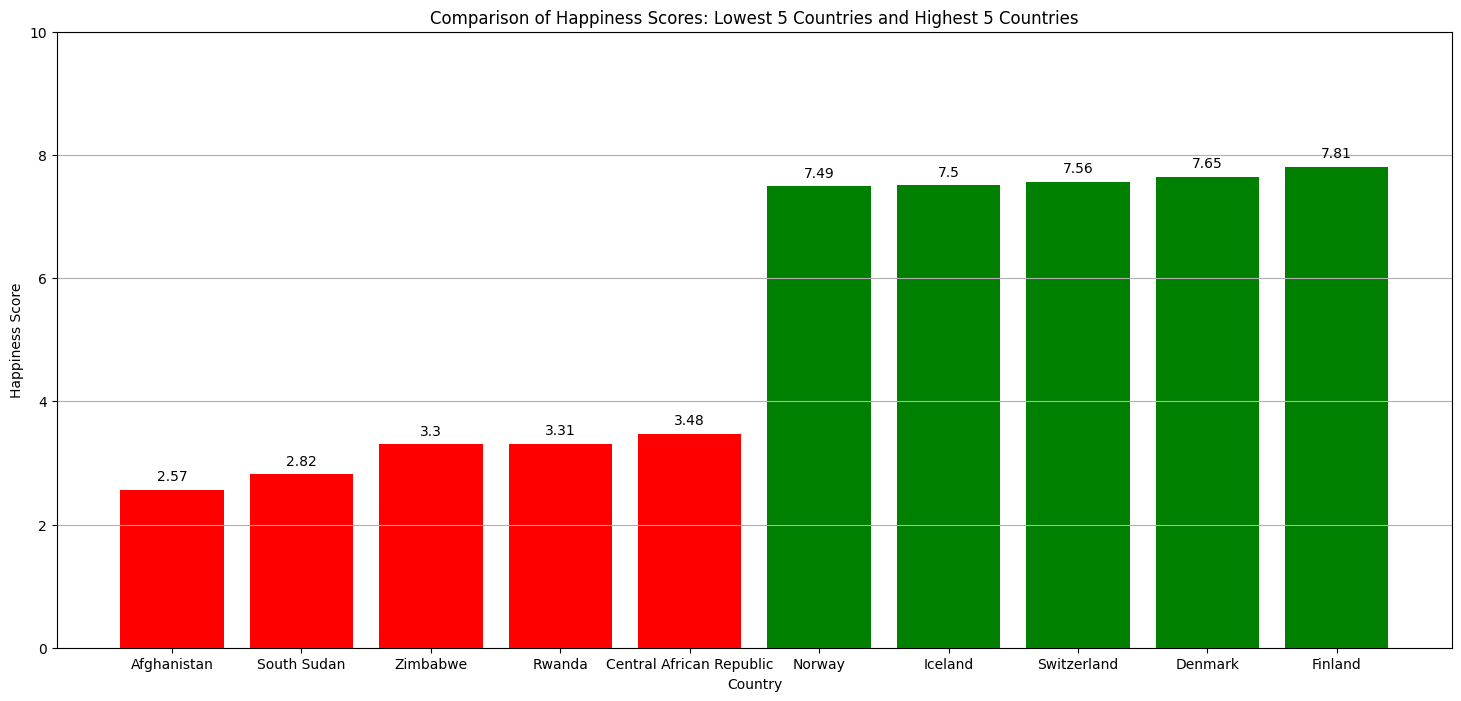

In [14]:
#Lowest 5 countries' happiness scores
lowest_5_happiness = df_main_renewed.nsmallest(5, 'happiness_score')

#Highest 5 countries' happiness scores
highest_5_happiness = df_main_renewed.nlargest(5, 'happiness_score').sort_values(by='happiness_score')

lowest_highest_5_happiness_score = pd.concat([lowest_5_happiness, highest_5_happiness])

#Combine the loweset 5 countries' data with the highest 5 countries' data
combined_happiness = pd.concat([lowest_5_happiness, highest_5_happiness])

#Plot the barchart
plt.figure(figsize=(18, 8))
bars = plt.bar(combined_happiness['country'], combined_happiness["happiness_score"], color=["red"]*5 + ["green"]*5)

#Paste bar-top labels to the graph
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

'''
plt.annotate(format(bar.get_height(), '.2f'), 
               (bar.get_x() + bar.get_width() / 2, 
                bar.get_height()), ha='center', va='center',
               size=15, xytext=(0, 8),
               textcoords='offset points')
'''

plt.xlabel("Country")
plt.ylabel("Happiness Score")
plt.title("Comparison of Happiness Scores: Lowest 5 Countries and Highest 5 Countries")
plt.xticks(rotation=0)
plt.ylim(0, 10)
plt.grid(axis='y')

plt.show()

Weighted happiness score of the World Bank defined world regions

In [15]:
#Extract regional mean of Happiness Scores
df_region = df_main_renewed.groupby('region').apply(lambda x: np.average(x['happiness_score'], weights=x['population_2020_mean'])).reset_index(name='weighted_happiness_score')

#Sort the dataframe by Happiness Scores
df_region = df_region.sort_values(by='weighted_happiness_score')

#Plot the bar chart
fig = px.bar(df_region, x='region', y='weighted_happiness_score', text='weighted_happiness_score',
             labels={'weighted_happiness_score': 'Happiness Score', 'region': 'Region'},
             title='Weighted Happiness Score by Regions')

#Paste bar-top labels to the graph
fig.update_traces(texttemplate='%{text:.3s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

#Plot a red line for overall mean of Happiness Scores
overall_weighted_happiness = w_happiness_score.mean
fig.add_shape(type='line', x0=-0.5, x1=len(df_region)-0.5, y0=overall_weighted_happiness, y1=overall_weighted_happiness,
              line=dict(color='Red', dash='dash'), name='Weighted Happiness Score')

#Plot a green line for Hong Kong's happiness score
hong_kong_happiness = df_main_renewed[df_main_renewed['country'] == 'Hong Kong S.A.R. of China']['happiness_score'].mean()
fig.add_shape(type='line', x0=-0.5, x1=len(df_region)-0.5, y0=hong_kong_happiness, y1=hong_kong_happiness,
              line=dict(color='Green', dash='dash'), name='Hong Kong Happiness Score')

#Add annotations
fig.add_annotation(x=0.99, y=0.99, text=f'Overall Weighted Mean Happiness Score: {overall_weighted_happiness:.2f}', showarrow=False, xref='paper', yref='paper', font=dict(color='Red'))
fig.add_annotation(x=0.99, y=0.95, text=f'Hong Kong Happiness Score: {hong_kong_happiness:.2f}', showarrow=False, xref='paper', yref='paper', font=dict(color='Green'))

#Set length of X-axis and Y-axis's labels
fig.update_layout(xaxis_tickangle=10, yaxis=dict(range=[0, 10]), margin=dict(t=50, l=25, r=25, b=25), legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99))
fig.update_xaxes(tickvals=df_region['region'], ticktext=[f'{region[:len(region)//2]}\n{region[len(region)//2:]}' for region in df_region['region']])

#Extent the X-axis
fig.update_layout(xaxis=dict(tickmode='array', tickvals=df_region['region'], ticktext=[f'{region[:len(region)//2]}\n{region[len(region)//2:]}' for region in df_region['region']], automargin=True))

fig.show()

C:\Users\plkcl\AppData\Local\Temp\ipykernel_30872\921335851.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Total Populations of the Income Groups

C:\Users\plkcl\AppData\Local\Temp\ipykernel_30872\1374518954.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



<Figure size 640x480 with 0 Axes>

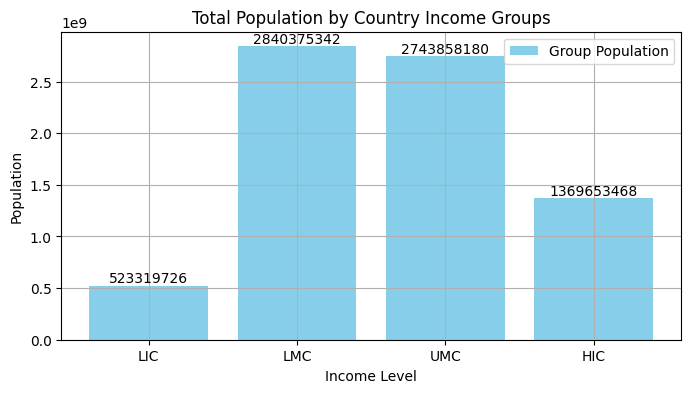

In [16]:
#Calculate group total populations by country income levels
group_total_population = df_main_renewed.groupby('income_level').apply(
    lambda x: x['population_2020_mean'].sum()
)

#Calculate the overall population score
overall_world_population = df_main_renewed['population_2020_mean'].sum()

#Extract population score of Hong Kong
hong_kong_population = df_main_renewed[df_main_renewed['country'] == 'Hong Kong S.A.R. of China']['population_2020_mean'].mean()

#List country income groups' populationaby specific order
income_levels = ['LIC', 'LMC', 'UMC', 'HIC']
group_total_population = group_total_population.reindex(income_levels)

#Clear the current figure
plt.clf()

#Plot the graph
plt.figure(figsize=(8, 4))
bars = plt.bar(group_total_population.index, group_total_population, color='skyblue', label='Group Population')

#Paste bar-top labels to the graph
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

#Add horizontal lines for overall and Hong Kong population scores
#plt.axhline(overall_world_population, color='red', linestyle='--', linewidth=2, label=f'Overall world population: {int(overall_world_population)}')
#plt.axhline(hong_kong_population, color='green', linestyle='--', linewidth=2, label=f'Population of Hong Kong: {int(hong_kong_population)}')

#Add labels and title
plt.xlabel('Income Level')
plt.ylabel('Population')
plt.title('Total Population by Country Income Groups')
plt.xticks(rotation=0)
#plt.ylim(0, 1100000000)

#Add legend and grid
plt.legend()
plt.grid()

#Show the plot
plt.show()

Weighted Mean Happiness Score by Country Income Groups

C:\Users\plkcl\AppData\Local\Temp\ipykernel_30872\804961639.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



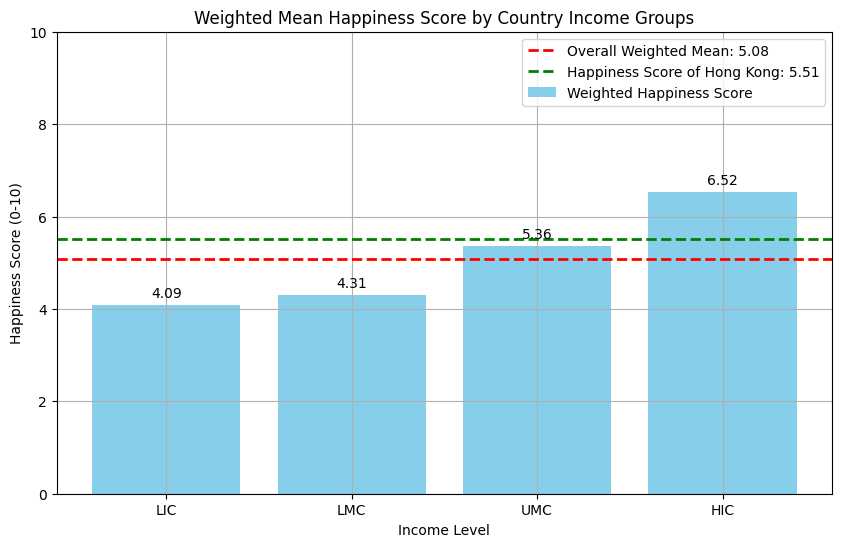

In [17]:
weighted_happiness = df_main_renewed.groupby('income_level').apply(
    lambda x: (x['happiness_score'] * x['population_2020_mean']).sum() / x['population_2020_mean'].sum())

#Calculate the overall mean happiness socre
overall_weighted_happiness = w_happiness_score.mean

#Extract happiness score of Hong Kong
hong_kong_happiness = df_main_renewed[df_main_renewed['country'] == 'Hong Kong S.A.R. of China']['happiness_score'].mean()

#List income groups' happiness score by specific order
income_levels = ['LIC', 'LMC', 'UMC', 'HIC']
weighted_happiness = weighted_happiness.reindex(income_levels)

#Plot the graph
plt.figure(figsize=(10, 6))
bars = plt.bar(weighted_happiness.index, weighted_happiness, color='skyblue', label='Weighted Happiness Score')

#Paste labels to the graph
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

plt.axhline(overall_weighted_happiness, color='red', linestyle='--', linewidth=2, label=f'Overall Weighted Mean: {overall_weighted_happiness:.2f}')
plt.axhline(hong_kong_happiness, color='green', linestyle='--', linewidth=2, label=f'Happiness Score of Hong Kong: {hong_kong_happiness:.2f}')

plt.xlabel('Income Level')
plt.ylabel('Happiness Score (0-10)')
plt.title('Weighted Mean Happiness Score by Country Income Groups')
plt.xticks(rotation=0)
plt.ylim(0, 10)

plt.legend()
plt.grid()

plt.show()

Weighted Mean GDP by Country Income Groups

C:\Users\plkcl\AppData\Local\Temp\ipykernel_30872\3741610879.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



<Figure size 640x480 with 0 Axes>

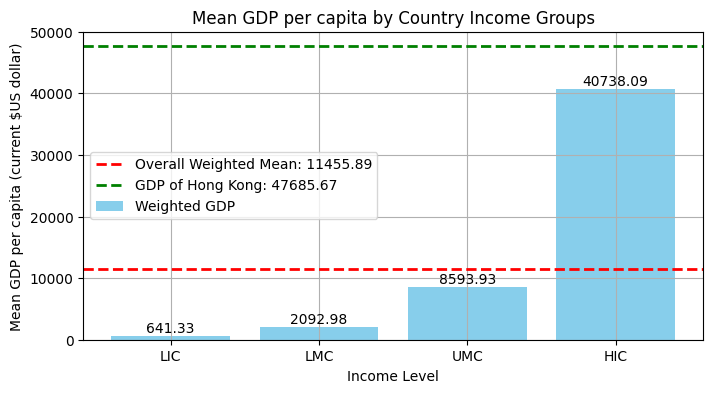

In [18]:
#Calculate weighted GDP by income level
weighted_gdp = df_main_renewed.groupby('income_level').apply(
    lambda x: (x['gdp_2020_mean'] * x['population_2020_mean']).sum() / x['population_2020_mean'].sum()
)

#Calculate the overall GDP score
overall_weighted_gdp = w_gdp_2020_mean.mean

#Extract GDP score of Hong Kong
hong_kong_gdp = df_main_renewed[df_main_renewed['country'] == 'Hong Kong S.A.R. of China']['gdp_2020_mean'].mean()

#List income groups' GDP score by specific order
income_levels = ['LIC', 'LMC', 'UMC', 'HIC']
weighted_gdp = weighted_gdp.reindex(income_levels)

#Clear the current figure
plt.clf()

#Plot the graph
plt.figure(figsize=(8, 4))
bars = plt.bar(weighted_gdp.index, weighted_gdp, color='skyblue', label='Weighted GDP')

#Paste bar-top labels to the graph
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

#Add horizontal lines for overall and Hong Kong GDP scores
plt.axhline(overall_weighted_gdp, color='red', linestyle='--', linewidth=2, label=f'Overall Weighted Mean: {overall_weighted_gdp:.2f}')
plt.axhline(hong_kong_gdp, color='green', linestyle='--', linewidth=2, label=f'GDP of Hong Kong: {hong_kong_gdp:.2f}')

#Add labels and title
plt.xlabel('Income Level')
plt.ylabel('Mean GDP per capita (current $US dollar)')
plt.title('Mean GDP per capita by Country Income Groups')
plt.xticks(rotation=0)
plt.ylim(0, 50000)

# Add legend and grid
plt.legend()
plt.grid()

# Show the plot
plt.show()

Treemap of Happiness Score of the overall Scores

In [19]:
#Plot the Treemap
fig = px.treemap(df_main_renewed, path=[px.Constant("Overall"), 'region'], values='population_2020_mean',
                 color='happiness_score', hover_data=['region'],
                 color_continuous_scale='solar',
                 color_continuous_midpoint=np.average(df_main_renewed['happiness_score'], weights=df_main_renewed['country_weight']))

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

Comparison of Country Population: The need of addition of sample weighting

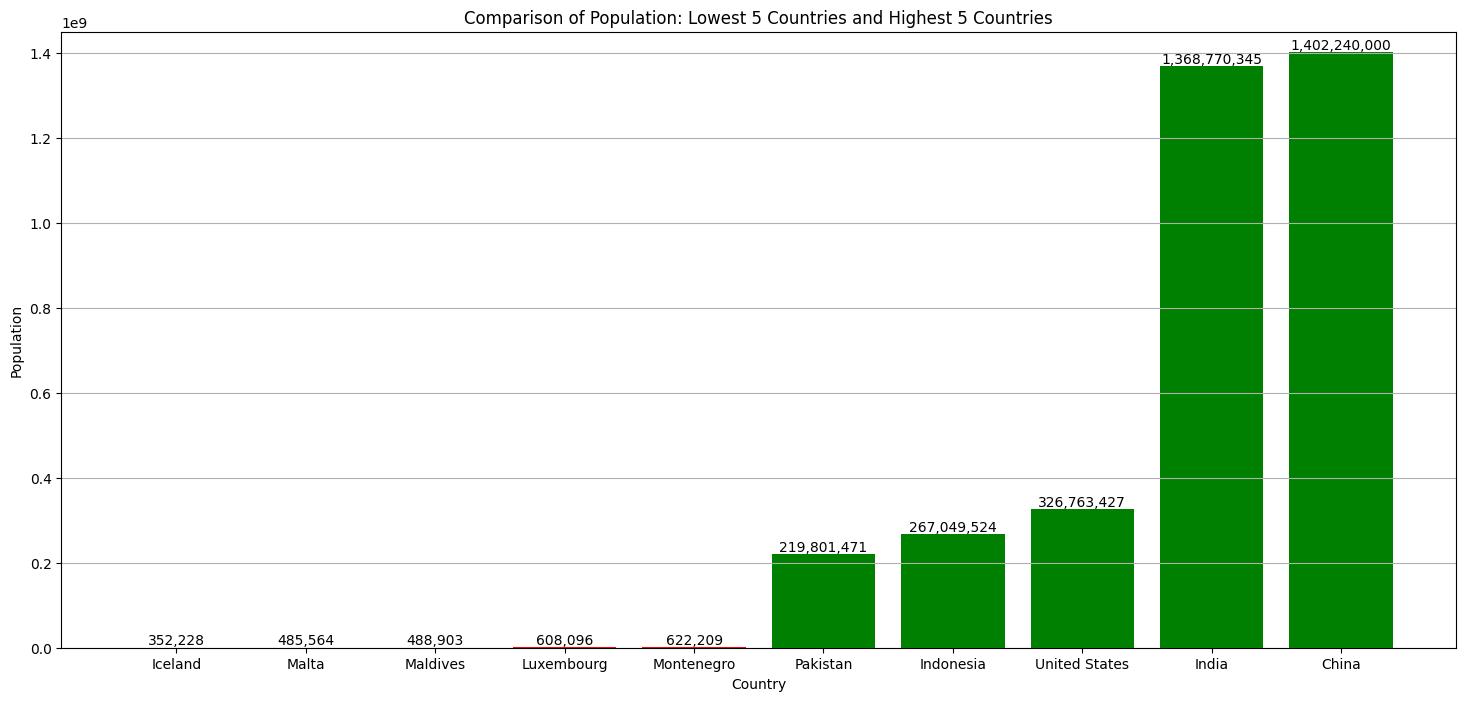

In [20]:
# Lowest 5 countries' population
lowest_5_population = df_main_renewed.nsmallest(5, 'population_2020_mean')

# Highest 5 countries' population
highest_5_population = df_main_renewed.nlargest(5, 'population_2020_mean').sort_values(by='population_2020_mean')

# Combine the lowest 5 countries' data with the highest 5 countries' data
combined_population = pd.concat([lowest_5_population, highest_5_population])

# Plot the bar chart
plt.figure(figsize=(18, 8))
bars = plt.bar(combined_population['country'], combined_population["population_2020_mean"], color=["red"]*5 + ["green"]*5)

# Add text annotations to display the population numbers on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', ha='center', va='bottom')

plt.xlabel("Country")
plt.ylabel("Population")
plt.title("Comparison of Population: Lowest 5 Countries and Highest 5 Countries")
plt.xticks(rotation=0)
plt.ylim(0, 1450000000)
plt.grid(axis='y')

plt.show()

In [21]:
#Load the database for regression
df_ols_regress = pd.read_csv('renewed_db_2020_ols_regression.csv', index_col=[0])

Pairwise correlations of happiness and the 6 indicators

In [22]:
#Drop the unfitted data of the independent variable
df_ols_regress = df_ols_regress.drop(columns=['gdp_2020_mean'])

#Perform Ordinary Least Squares regression (OLS) without countries' weightings
ols_matrix = df_ols_regress.corr(numeric_only = True)

print(ols_matrix)

                              happiness_score  gdp_2020_log  le_2020_mean  \
happiness_score                      1.000000      0.825756      0.763885   
gdp_2020_log                         0.825756      1.000000      0.875459   
le_2020_mean                         0.763885      0.875459      1.000000   
social_support                       0.765001      0.768982      0.723536   
freedom_to_make_life_choices         0.590597      0.433973      0.423110   
generosity                           0.069043     -0.073722     -0.061926   
perceptions_of_corruption           -0.418305     -0.395099     -0.331087   

                              social_support  freedom_to_make_life_choices  \
happiness_score                     0.765001                      0.590597   
gdp_2020_log                        0.768982                      0.433973   
le_2020_mean                        0.723536                      0.423110   
social_support                      1.000000                      0.478

OLS Triangle Correlation Heatmap

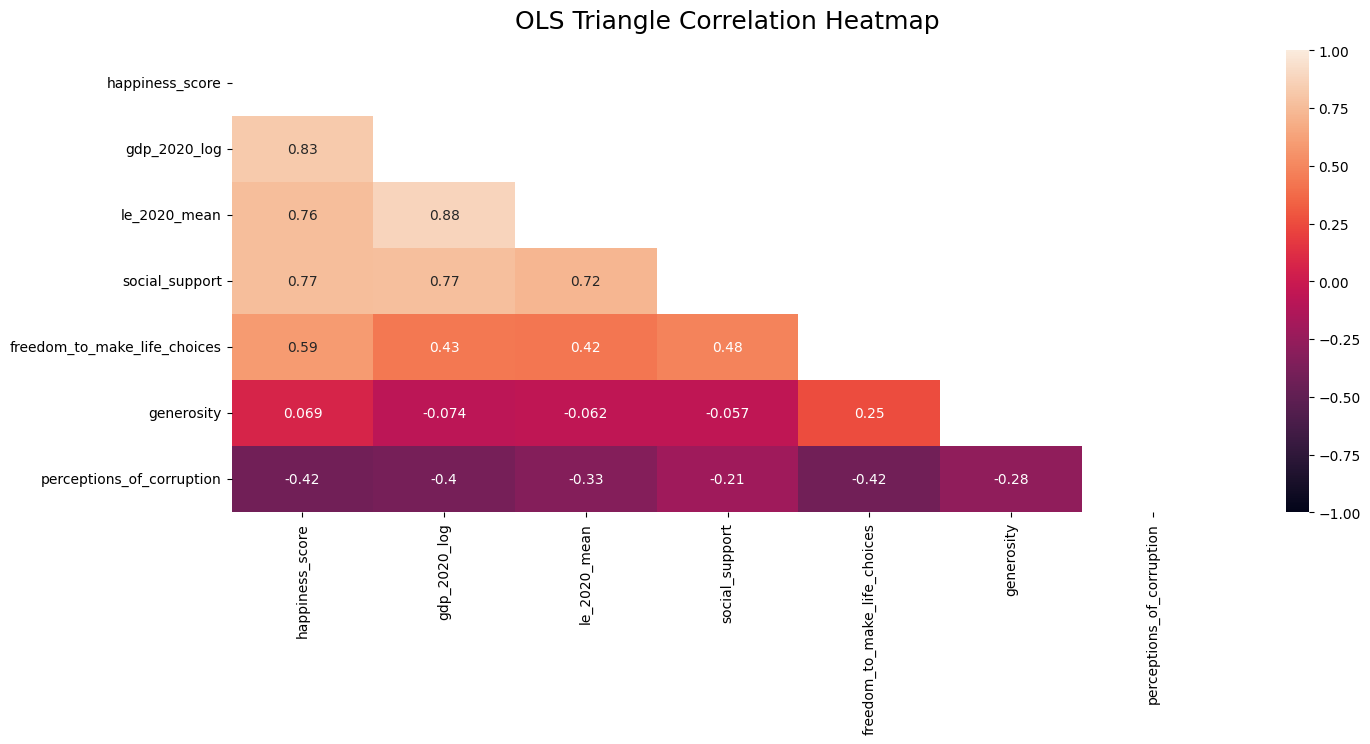

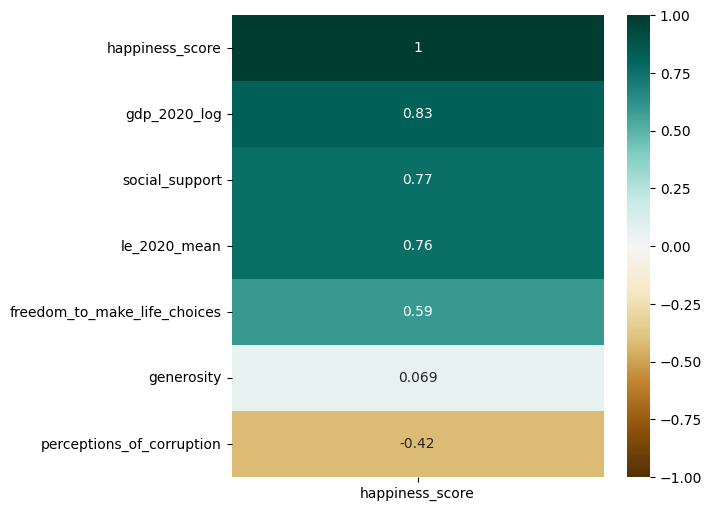

In [23]:
plt.figure(figsize=(16, 6))

#Generate OLS Triangle Correlation Heatmap
mask = np.triu(np.ones_like(ols_matrix, dtype=bool))
ols_heatmap = sns.heatmap(ols_matrix, mask=mask, vmin=-1, vmax=1, annot=True)
ols_heatmap.set_title('OLS Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

#Figure out the correlations of the indicators to the dependant variable (happiness score)
plt.figure(figsize=(6, 6))
ols_heatmap_2 = sns.heatmap(ols_matrix[['happiness_score']].sort_values(by='happiness_score', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

#ols_heatmap_2.set_title('OLS Features correlating with Happiness Score', fontdict={'fontsize':18}, pad=16);

Pairplot of happiness score against the 6 indicators

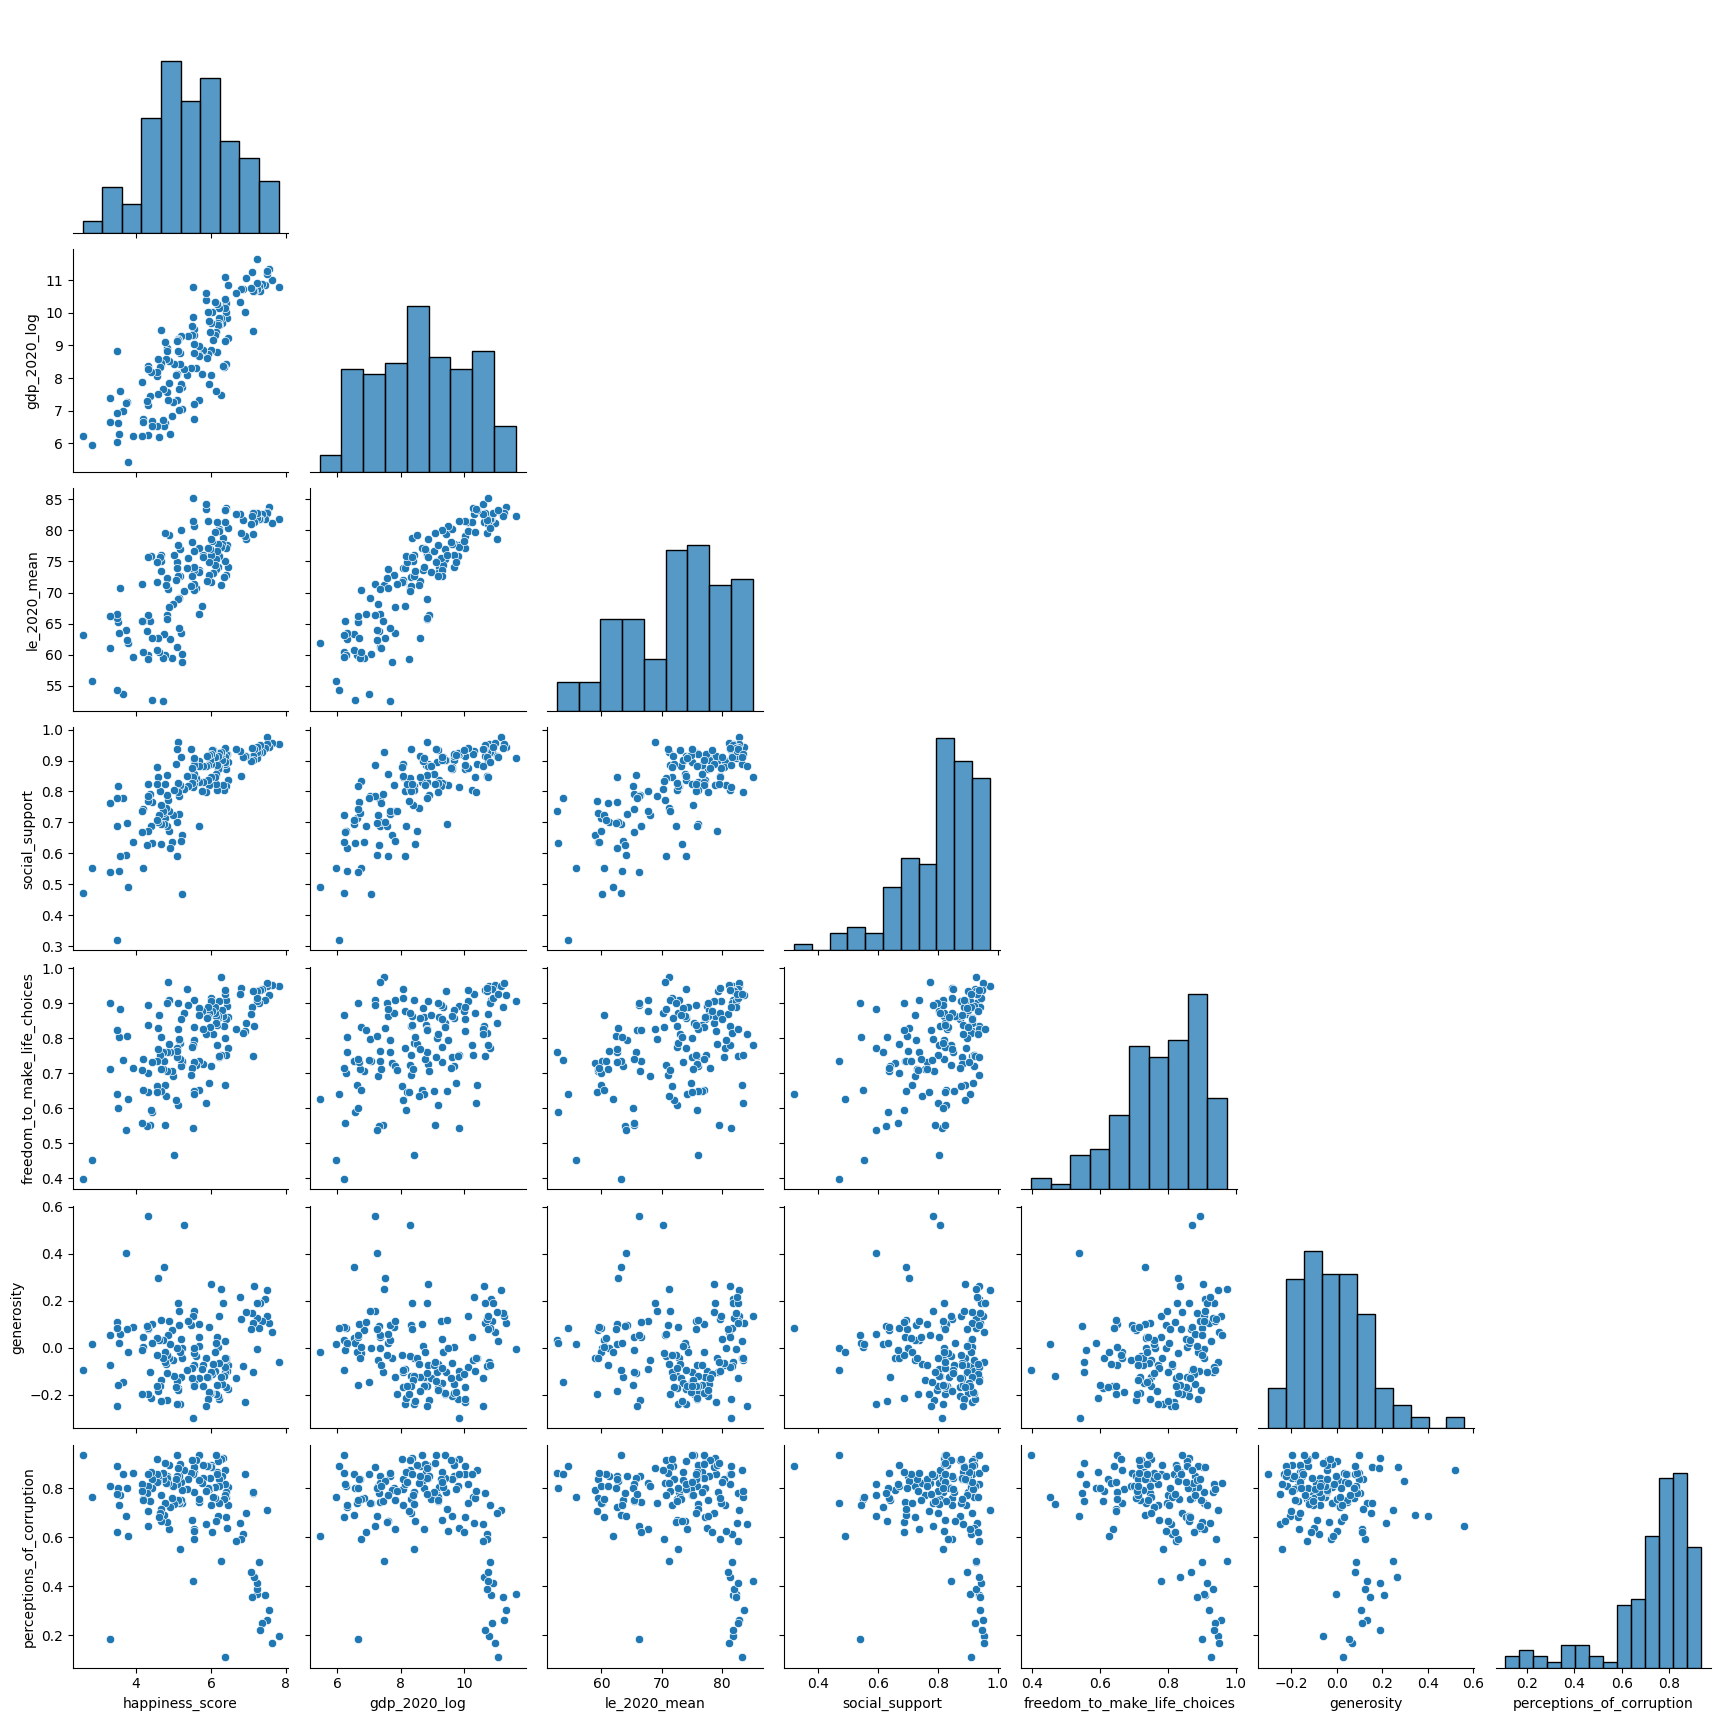

In [24]:
sns.pairplot(df_main_renewed[['happiness_score','gdp_2020_log', 'le_2020_mean','social_support', 'freedom_to_make_life_choices','generosity', 'perceptions_of_corruption']], kind="scatter", corner=True)

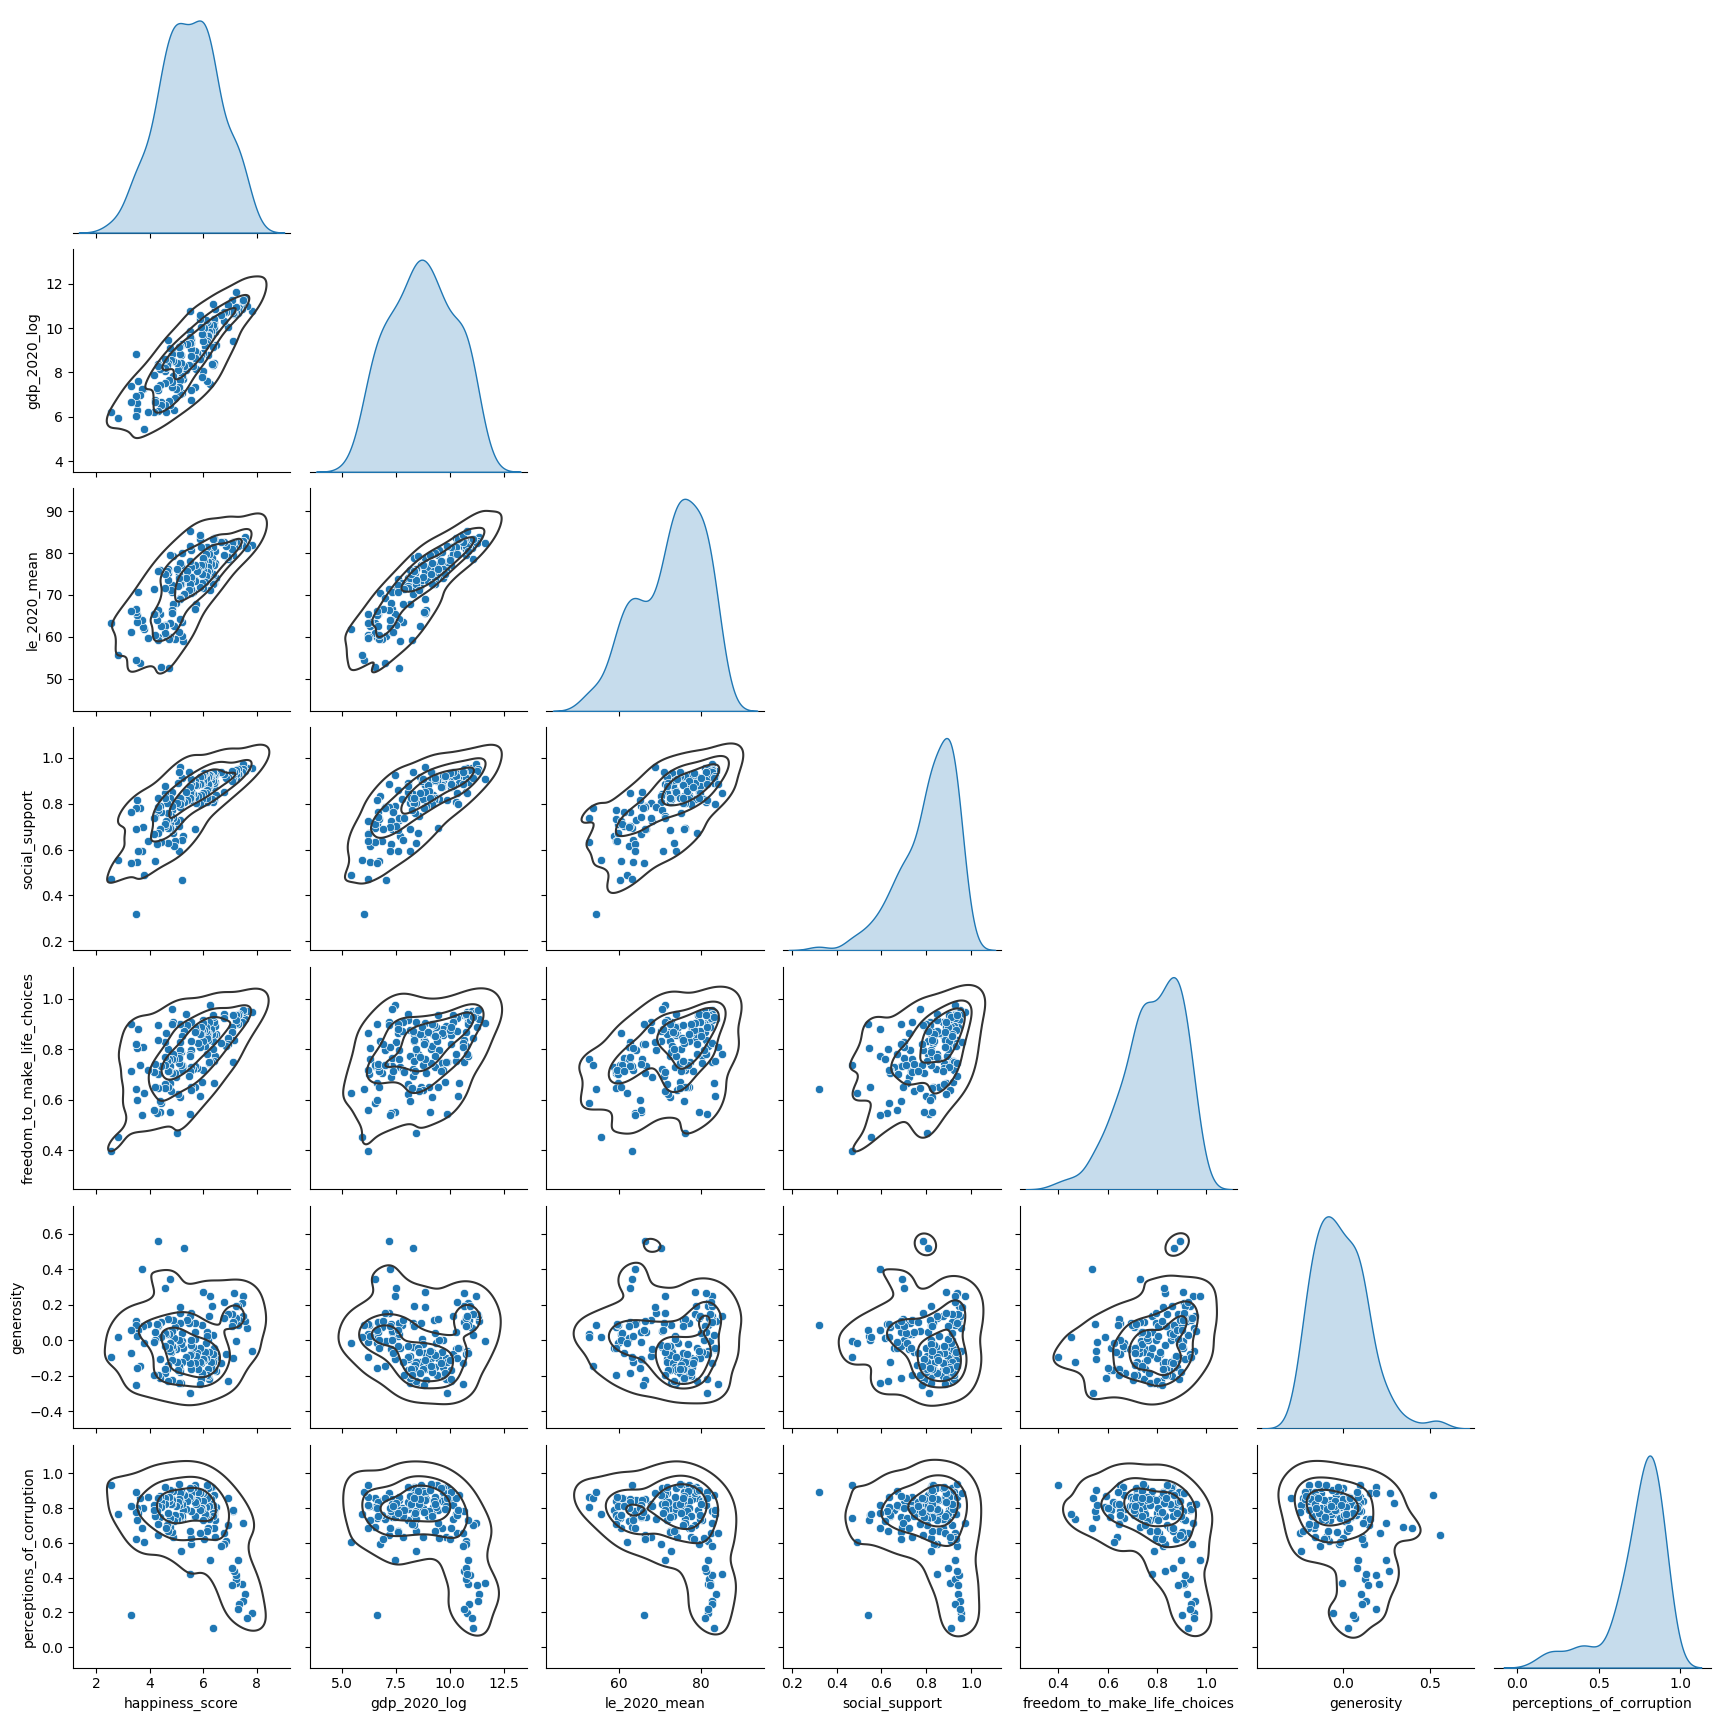

In [25]:
g = sns.pairplot(df_main_renewed[['happiness_score','gdp_2020_log', 'le_2020_mean','social_support', 'freedom_to_make_life_choices','generosity', 'perceptions_of_corruption']], diag_kind="kde", corner=True)
g.map_lower(sns.kdeplot, levels=4, color=".2")

Hong Kong's case

In [26]:
df_main_renewed[df_main_renewed['country_code'].str.contains('HKG')]

,country_code,country,region,income_level,population_2020_mean,happiness_score,gdp_2020_mean,gdp_2020_log,le_2020_mean,social_support,freedom_to_make_life_choices,generosity,perceptions_of_corruption,country_weight
161,HKG,Hong Kong S.A.R. of China,East Asia,HIC,7451233.333,5.5104,47685.66596,10.772386,85.1393,0.845969,0.779834,0.13498,0.420607,0.000964


In [27]:
fig = px.choropleth(df_main_renewed, 
                    locations="country", 
                    locationmode="country names",
                    color="gdp_2020_mean",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.solar,
                    title="GDP by countries").update_layout(title_x=0.5,coloraxis_colorbar=dict(title="current US$"))

fig.show()

Weighted Mean GDP by Country Income Groups

C:\Users\plkcl\AppData\Local\Temp\ipykernel_30872\2678807909.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



<Figure size 640x480 with 0 Axes>

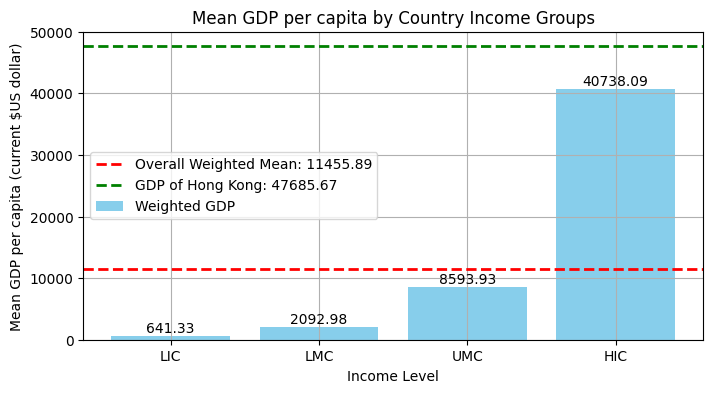

In [28]:

#Calculate weighted GDP by income level
weighted_gdp = df_main_renewed.groupby('income_level').apply(
    lambda x: (x['gdp_2020_mean'] * x['population_2020_mean']).sum() / x['population_2020_mean'].sum()
)

#Calculate the overall GDP score
overall_weighted_gdp = w_gdp_2020_mean.mean

#Extract GDP score of Hong Kong
hong_kong_gdp = df_main_renewed[df_main_renewed['country'] == 'Hong Kong S.A.R. of China']['gdp_2020_mean'].mean()

#List income groups' GDP score by specific order
income_levels = ['LIC', 'LMC', 'UMC', 'HIC']
weighted_gdp = weighted_gdp.reindex(income_levels)

#Clear the current figure
plt.clf()

#Plot the graph
plt.figure(figsize=(8, 4))
bars = plt.bar(weighted_gdp.index, weighted_gdp, color='skyblue', label='Weighted GDP')

#Paste bar-top labels to the graph
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

#Add horizontal lines for overall and Hong Kong GDP scores
plt.axhline(overall_weighted_gdp, color='red', linestyle='--', linewidth=2, label=f'Overall Weighted Mean: {overall_weighted_gdp:.2f}')
plt.axhline(hong_kong_gdp, color='green', linestyle='--', linewidth=2, label=f'GDP of Hong Kong: {hong_kong_gdp:.2f}')

#Add labels and title
plt.xlabel('Income Level')
plt.ylabel('Mean GDP per capita (current $US dollar)')
plt.title('Mean GDP per capita by Country Income Groups')
plt.xticks(rotation=0)
plt.ylim(0, 50000)

# Add legend and grid
plt.legend()
plt.grid()

# Show the plot
plt.show()

Weighted Mean Happiness Score by Country Income Groups

C:\Users\plkcl\AppData\Local\Temp\ipykernel_30872\804961639.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



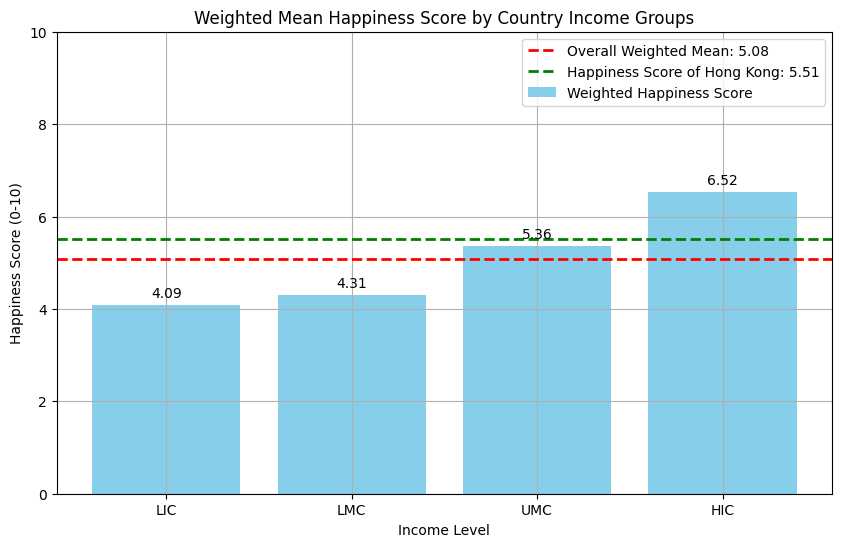

In [29]:
weighted_happiness = df_main_renewed.groupby('income_level').apply(
    lambda x: (x['happiness_score'] * x['population_2020_mean']).sum() / x['population_2020_mean'].sum())

#Calculate the overall mean happiness socre
overall_weighted_happiness = w_happiness_score.mean

#Extract happiness score of Hong Kong
hong_kong_happiness = df_main_renewed[df_main_renewed['country'] == 'Hong Kong S.A.R. of China']['happiness_score'].mean()

#List income groups' happiness score by specific order
income_levels = ['LIC', 'LMC', 'UMC', 'HIC']
weighted_happiness = weighted_happiness.reindex(income_levels)

#Plot the graph
plt.figure(figsize=(10, 6))
bars = plt.bar(weighted_happiness.index, weighted_happiness, color='skyblue', label='Weighted Happiness Score')

#Paste labels to the graph
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

plt.axhline(overall_weighted_happiness, color='red', linestyle='--', linewidth=2, label=f'Overall Weighted Mean: {overall_weighted_happiness:.2f}')
plt.axhline(hong_kong_happiness, color='green', linestyle='--', linewidth=2, label=f'Happiness Score of Hong Kong: {hong_kong_happiness:.2f}')

plt.xlabel('Income Level')
plt.ylabel('Happiness Score (0-10)')
plt.title('Weighted Mean Happiness Score by Country Income Groups')
plt.xticks(rotation=0)
plt.ylim(0, 10)

plt.legend()
plt.grid()

plt.show()

World overview of Log(GDP) among countries

In [30]:
fig = px.choropleth(df_main_renewed, 
                    locations="country", 
                    locationmode="country names",
                    color="gdp_2020_log",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.solar,
                    title="Log(GDP per capita)").update_layout(title_x=0.5,coloraxis_colorbar=dict(title="Log(GDP)"))

fig.show()

Correlations of Happiness Score against Mean GPD per capita

In [31]:
#Prepare mean of Happiness Score against GDP per capita without Country Population Weighting
happiness_score_2020_test = np.array(df_main_renewed['happiness_score'])
gdp_2020_mean_test = np.array(df_main_renewed['gdp_2020_mean'])
population_2020_mean_test = np.array(df_main_renewed['population_2020_mean'])
df_country_weight_test = df_country_weight['country_weight']

fig = df_main_renewed.plot.scatter(x="gdp_2020_mean", y="happiness_score", trendline="ols", hover_data = "country", title="GDP per capita / Happiness Score").update_layout(xaxis_title="GDP per capita (in current US$)", yaxis_title="Ladder (Happiness) Score (0-10)")
fig.update_xaxes(showgrid=True, zeroline=True)
fig.update_yaxes(showgrid=True, zeroline=True)

fig.show()

In [32]:
#Prepare mean of Happiness Score against GDP per capita without Country Population Weighting
happiness_score_2020_test = np.array(df_main_renewed['happiness_score'])
gdp_2020_mean_test = np.array(df_main_renewed['gdp_2020_mean'])
population_2020_mean_test = np.array(df_main_renewed['population_2020_mean'])
df_country_weight_test = df_country_weight['country_weight']

fig = df_main_renewed.plot.scatter(x="gdp_2020_mean", y="happiness_score", trendline="lowess", hover_data = "country", title="GDP per capita / Happiness Score").update_layout(xaxis_title="GDP per capita (in current US$)", yaxis_title="Ladder (Happiness) Score (0-10)")
fig.update_xaxes(showgrid=True, zeroline=True)
fig.update_yaxes(showgrid=True, zeroline=True)

fig.show()

Regression of Happiness Score against Mean GDP per capita

In [33]:
#Get data x: GDP per capita, y: Happiness Score
X = gdp_2020_mean_test
y = happiness_score_2020_test

#Fit OLS regression model
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

#Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     169.5
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           1.85e-26
Time:                        14:36:20   Log-Likelihood:                -175.29
No. Observations:                 153   AIC:                             354.6
Df Residuals:                     151   BIC:                             360.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8760      0.077     63.276      0.0

In [34]:
#Get data x: GDP per capita, y: Happiness Score
X = gdp_2020_mean_test
y = happiness_score_2020_test

#Fit WLS regression model
X = sm.add_constant(X)
model = sm.WLS(y, X, weights=w)
results = model.fit()

#Print regression results
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.505
Model:                            WLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     153.8
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           8.49e-25
Time:                        14:36:20   Log-Likelihood:                -277.75
No. Observations:                 153   AIC:                             559.5
Df Residuals:                     151   BIC:                             565.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5426      0.076     59.905      0.0

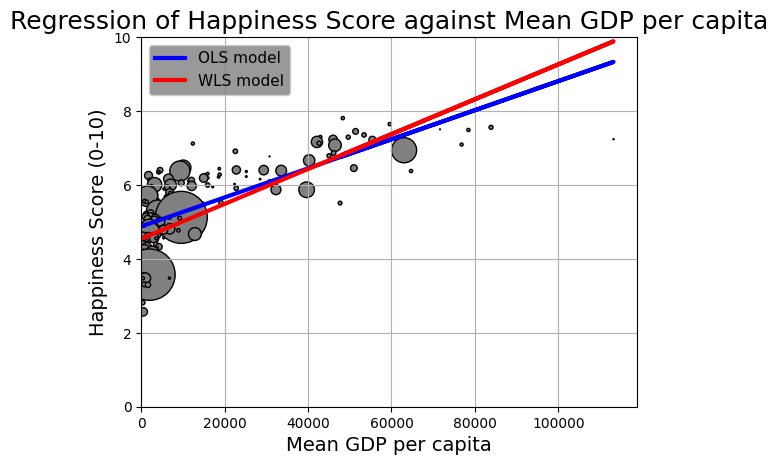

In [35]:
#Prepare Happiness Score, log of GDP per capita with Country Population Weighting
happiness_score_2020_test = np.array(df_main_renewed['happiness_score'])
gdp_2020_mean_test = np.array(df_main_renewed['gdp_2020_mean'])
population_2020_mean_test = np.array(df_main_renewed['population_2020_mean'])
df_country_weight_test = df_country_weight['country_weight']

#Prepare the dafaframe for testing
w_hs_gdp = pd.DataFrame({"GDP per capita": gdp_2020_mean_test, "Happiness Score": happiness_score_2020_test, "Mean of Country Population (2017-2019)": population_2020_mean_test, "Weighting of Country": df_country_weight_test})

#Split the data into input features (x) and target variable (y)
x = w_hs_gdp[['GDP per capita']]
y = w_hs_gdp['Happiness Score']
s_p = w_hs_gdp['Mean of Country Population (2017-2019)']
w = w_hs_gdp['Weighting of Country']


plt.scatter(x, y, s=s_p/1000000, edgecolor='black', color='grey')
 
#Gernerate a Ordinary Least Squares (OLS) regression model
linear_model = LinearRegression()
linear_model.fit(x, y)

#Generate a Weighted Least Squares (WLS) model
weighted_model = LinearRegression()
weighted_model.fit(x, y, w)

#Set the graph to show zero at both x-axis and y-axis
plt.xlim(left=0)
plt.ylim(0, 10)

#Plot the unweighted model
regr_l = LinearRegression()
regr_l.fit(x, y)
plt.plot(x, regr_l.predict(x), color='blue', linewidth=3, label='OLS model')

#Plot the weighted model
regr_w = LinearRegression()
regr_w.fit(x, y, w)
plt.plot(x, regr_w.predict(x), color='red', linewidth=3, label='WLS model')

plt.grid()

plt.xlabel('Mean GDP per capita', fontsize=14)
plt.ylabel('Happiness Score (0-10)', fontsize=14)
plt.legend(facecolor='grey', fontsize=11)

plt.title('Regression of Happiness Score against Mean GDP per capita', fontsize=18)

plt.show()

Correlations of Happiness Score against Log(GPD per capita)

In [36]:
#Prepare Happiness Score against Log(GDP per capita) without Country Population Weighting
happiness_score_2020_test = np.array(df_main_renewed['happiness_score'])
gdp_2020_log_test = np.array(df_main_renewed['gdp_2020_log'])
population_2020_mean_test = np.array(df_main_renewed['population_2020_mean'])
df_country_weight_test = df_country_weight['country_weight']

fig = df_main_renewed.plot.scatter(x="gdp_2020_log", y="happiness_score", trendline="ols", hover_data = "country", title="Log(GDP per capita) / Happiness Score").update_layout(xaxis_title="Log(GDP per capita)", yaxis_title="Ladder (Happiness) Score (0-10)")
fig.update_xaxes(showgrid=True, zeroline=True)
fig.update_yaxes(showgrid=True, zeroline=True)

fig.show()

Regression of Happiness Score against Log(GDP per capita)

In [37]:
#Get data x: Log(GDP per capita), y: Happiness Score
X = gdp_2020_log_test
y = happiness_score_2020_test

#Fit OLS regression model
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

#Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     323.7
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           2.19e-39
Time:                        14:36:20   Log-Likelihood:                -145.26
No. Observations:                 153   AIC:                             294.5
Df Residuals:                     151   BIC:                             300.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0614      0.305      0.201      0.8

In [38]:
#Get data x: Log(GDP per capita), y: Happiness Score
X = gdp_2020_log_test
y = happiness_score_2020_test

#Fit WLS regression model
X = sm.add_constant(X)
model = sm.WLS(y, X, weights=w)
results = model.fit()

#Print regression results
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.607
Model:                            WLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     233.2
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           1.99e-32
Time:                        14:36:20   Log-Likelihood:                -260.04
No. Observations:                 153   AIC:                             524.1
Df Residuals:                     151   BIC:                             530.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7369      0.385     -1.913      0.0

C:\Users\plkcl\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

C:\Users\plkcl\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



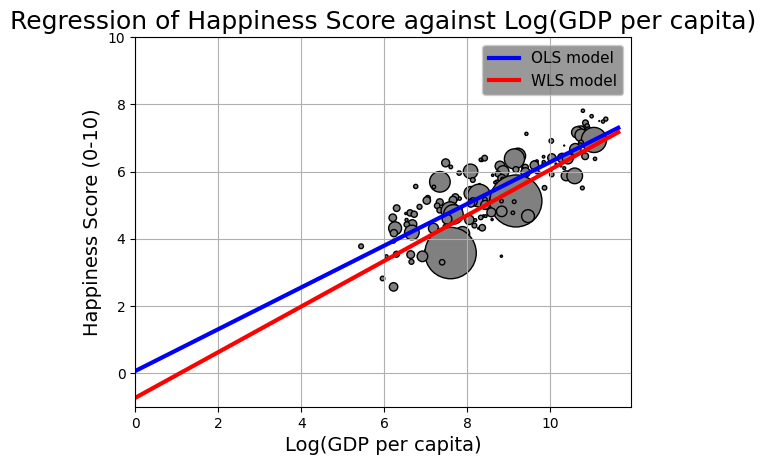

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Prepare Happiness Score, log of GDP per capita with Country Population Weighting
happiness_score_2020_test = np.array(df_main_renewed['happiness_score'])
gdp_2020_log_test = np.array(df_main_renewed['gdp_2020_log'])
population_2020_mean_test = np.array(df_main_renewed['population_2020_mean'])
df_country_weight_test = df_country_weight['country_weight']

# Prepare the dataframe for testing
w_hs_gdp = pd.DataFrame({"Log(GDP per capita)": gdp_2020_log_test, "Happiness Score": happiness_score_2020_test, "Mean of Country Population (2017-2019)": population_2020_mean_test, "Weighting of Country": df_country_weight_test})

# Split the data into input features (x) and target variable (y)
x = w_hs_gdp[['Log(GDP per capita)']]
y = w_hs_gdp['Happiness Score']
s_p = w_hs_gdp['Mean of Country Population (2017-2019)']
w = w_hs_gdp['Weighting of Country']

plt.scatter(x, y, s=s_p/1000000, edgecolor='black', color='grey')

# Generate a Ordinary Least Squares (OLS) regression model
linear_model = LinearRegression()
linear_model.fit(x, y)

# Generate a Weighted Least Squares (WLS) model
weighted_model = LinearRegression()
weighted_model.fit(x, y, w)

# Set the graph to show zero at both x-axis and y-axis
plt.xlim(left=0)
plt.ylim(-1, 10)

# Extend the range of x for plotting the regression lines
x_range = np.linspace(0, x.max(), 100).reshape(-1, 1)

# Plot the unweighted model
plt.plot(x_range, linear_model.predict(x_range), color='blue', linewidth=3, label='OLS model')

# Plot the weighted model
plt.plot(x_range, weighted_model.predict(x_range), color='red', linewidth=3, label='WLS model')

plt.grid()

plt.xlabel('Log(GDP per capita)', fontsize=14)
plt.ylabel('Happiness Score (0-10)', fontsize=14)
plt.legend(facecolor='grey', fontsize=11)

plt.title('Regression of Happiness Score against Log(GDP per capita)', fontsize=18)

plt.show()

Social Support Score / Happiness Score

In [40]:
fig = px.choropleth(df_main_renewed, 
                    locations="country", 
                    locationmode="country names",
                    color="social_support",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.Pinkyl,
                    title="Social Support Score (0-1))").update_layout(title_x=0.5,coloraxis_colorbar=dict(title="Social Support Score"))

fig.show()

Weighted Mean Social Support Score by Country Income Groups

C:\Users\plkcl\AppData\Local\Temp\ipykernel_30872\3286853111.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



<Figure size 640x480 with 0 Axes>

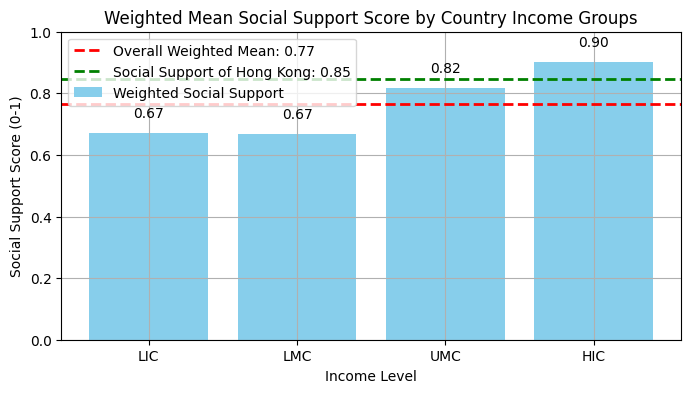

In [41]:
#Calculate weighted social support by income level
weighted_social_support = df_main_renewed.groupby('income_level').apply(lambda x: (x['social_support'] * x['population_2020_mean']).sum() / x['population_2020_mean'].sum())

#Calculate the overall social support score
overall_weighted_social_support = w_social_support.mean

#Extract social support score of Hong Kong
hong_kong_social_support = df_main_renewed[df_main_renewed['country'] == 'Hong Kong S.A.R. of China']['social_support'].mean()

#List income groups' social support score by specific order
income_levels = ['LIC', 'LMC', 'UMC', 'HIC']
weighted_social_support = weighted_social_support.reindex(income_levels)

#Clear the current figure
plt.clf()

#Plot the graph
plt.figure(figsize=(8, 4))
bars = plt.bar(weighted_social_support.index, weighted_social_support, color='skyblue', label='Weighted Social Support')

#Paste bar-top labels to the graph
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.04, f'{yval:.2f}', ha='center', va='bottom')

#Add horizontal lines for overall and Hong Kong social support scores
plt.axhline(overall_weighted_social_support, color='red', linestyle='--', linewidth=2, label=f'Overall Weighted Mean: {overall_weighted_social_support:.2f}')
plt.axhline(hong_kong_social_support, color='green', linestyle='--', linewidth=2, label=f'Social Support of Hong Kong: {hong_kong_social_support:.2f}')

#Add labels and title
plt.xlabel('Income Level')
plt.ylabel('Social Support Score (0-1)')
plt.title('Weighted Mean Social Support Score by Country Income Groups')
plt.xticks(rotation=0)
plt.ylim(0, 1)

#Add legend and grid
plt.legend()
plt.grid()

#Show the plot
plt.show()

Correlation of Happines Score against Social Support Score

In [42]:
#Prepare mean of Happiness Score against Social Support Score without Country Population Weighting
happiness_score_2020_test = np.array(df_main_renewed['happiness_score'])
social_support_test = np.array(df_main_renewed['social_support'])
population_2020_mean_test = np.array(df_main_renewed['population_2020_mean'])
df_country_weight_test = df_country_weight['country_weight']

fig = df_main_renewed.plot.scatter(x="social_support", y="happiness_score", trendline="ols", hover_data = "country", title="Social Support Score / Happiness Score").update_layout(xaxis_title="Social Support Score (0-1)", yaxis_title="Ladder (Happiness) Score (0-10)"
)
fig.show()

Regression of Happiness Score against Social Support Score

In [43]:
#Get data x: Social Support Score, y: Happiness Score
X = social_support_test
y = happiness_score_2020_test

#Fit OLS regression model
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

#Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     213.1
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           1.18e-30
Time:                        14:36:21   Log-Likelihood:                -165.55
No. Observations:                 153   AIC:                             335.1
Df Residuals:                     151   BIC:                             341.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1926      0.392     -0.491      0.6

In [44]:
#Get data x: Social Support Score, y: Happiness Score
X = social_support_test
y = happiness_score_2020_test

#Fit WLS regression model
X = sm.add_constant(X)
model = sm.WLS(y, X, weights=w)
results = model.fit()

#Print regression results
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.763
Model:                            WLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     486.5
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           4.39e-49
Time:                        14:36:21   Log-Likelihood:                -221.29
No. Observations:                 153   AIC:                             446.6
Df Residuals:                     151   BIC:                             452.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1811      0.287     -4.112      0.0

Regression of Happiness Score against Social Support Score

C:\Users\plkcl\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

C:\Users\plkcl\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



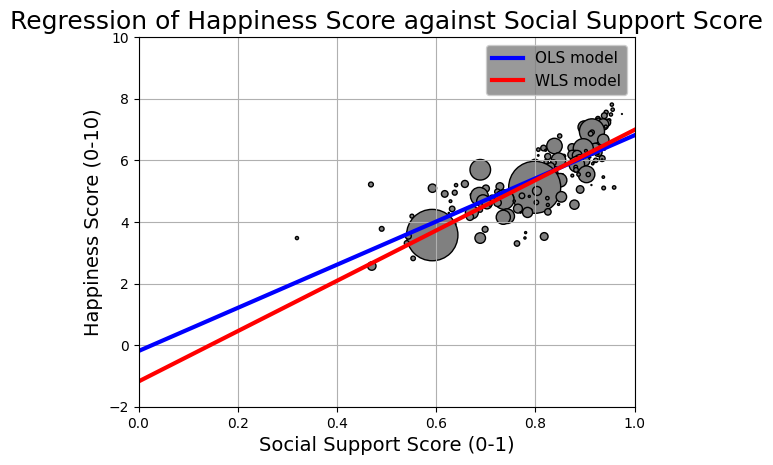

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Prepare Happiness Score, Social Support with Country Population Weighting
happiness_score_2020_test = np.array(df_main_renewed['happiness_score'])
social_support_test = np.array(df_main_renewed['social_support'])
population_2020_mean_test = np.array(df_main_renewed['population_2020_mean'])
df_country_weight_test = df_country_weight['country_weight']

# Prepare the dataframe for testing
w_hs_le = pd.DataFrame({"Social Support": social_support_test, "Happiness Score": happiness_score_2020_test, "Mean of Country Population (2017-2019)": population_2020_mean_test, "Weighting of Country": df_country_weight_test})

# Split the data into input features (x) and target variable (y)
x = w_hs_le[['Social Support']]
y = w_hs_le['Happiness Score']
s_p = w_hs_le['Mean of Country Population (2017-2019)']
w = w_hs_le['Weighting of Country']

plt.scatter(x, y, s=s_p/1000000, edgecolor='black', color='grey')

# Generate a Ordinary Least Squares (OLS) regression model
linear_model = LinearRegression()
linear_model.fit(x, y)

# Generate a Weighted Least Squares (WLS) model
weighted_model = LinearRegression()
weighted_model.fit(x, y, w)

# Set the graph to show zero at both x-axis and y-axis
plt.xlim(0, 1)
plt.ylim(-2, 10)

# Extend the range of x for plotting the regression lines
x_range = np.linspace(0, 1, 100).reshape(-1, 1)

# Plot the unweighted model
plt.plot(x_range, linear_model.predict(x_range), color='blue', linewidth=3, label='OLS model')

# Plot the weighted model
plt.plot(x_range, weighted_model.predict(x_range), color='red', linewidth=3, label='WLS model')

plt.grid()

plt.xlabel('Social Support Score (0-1)', fontsize=14)
plt.ylabel('Happiness Score (0-10)', fontsize=14)
plt.legend(facecolor='grey', fontsize=11)

plt.title('Regression of Happiness Score against Social Support Score', fontsize=18)

plt.show()

Life Expectancy at birth by Countries

In [46]:
fig = px.choropleth(df_main_renewed, 
                    locations="country", 
                    locationmode="country names",
                    color="le_2020_mean",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.Plotly3,
                    title="Life Expectancy at birth by Countries").update_layout(title_x=0.5,coloraxis_colorbar=dict(title="Life Expectancy"))

fig.show()

Weighted Mean Life Expectancy by Country Income Groups

C:\Users\plkcl\AppData\Local\Temp\ipykernel_30872\96539941.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



<Figure size 640x480 with 0 Axes>

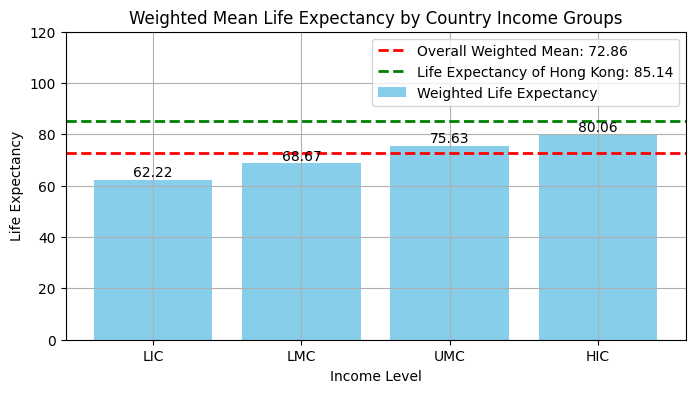

In [47]:
#Calculate weighted life expectancy by income level
weighted_le = df_main_renewed.groupby('income_level').apply(
    lambda x: (x['le_2020_mean'] * x['population_2020_mean']).sum() / x['population_2020_mean'].sum()
)

#Calculate the overall life expectancy score
overall_weighted_le = w_le_2020_mean.mean

#Extract life expectancy score of Hong Kong
hong_kong_le = df_main_renewed[df_main_renewed['country'] == 'Hong Kong S.A.R. of China']['le_2020_mean'].mean()

#List income groups' life expectancy score by specific order
income_levels = ['LIC', 'LMC', 'UMC', 'HIC']
weighted_le = weighted_le.reindex(income_levels)

#Clear the current figure
plt.clf()

#Plot the graph
plt.figure(figsize=(8, 4))  # Adjusted figure size
bars = plt.bar(weighted_le.index, weighted_le, color='skyblue', label='Weighted Life Expectancy')

#Paste bar-top labels to the graph
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.2f}', ha='center', va='bottom')

#Add horizontal lines for overall and Hong Kong life expectancy scores
plt.axhline(overall_weighted_le, color='red', linestyle='--', linewidth=2, label=f'Overall Weighted Mean: {overall_weighted_le:.2f}')
plt.axhline(hong_kong_le, color='green', linestyle='--', linewidth=2, label=f'Life Expectancy of Hong Kong: {hong_kong_le:.2f}')

#Add labels and title
plt.xlabel('Income Level')
plt.ylabel('Life Expectancy')
plt.title('Weighted Mean Life Expectancy by Country Income Groups')
plt.xticks(rotation=0)
plt.ylim(0, 120)

#Add legend and grid
plt.legend()
plt.grid()

#Show the plot
plt.show()

Corrrelation of Happiness Score against Healthy Life Expectancy at Birth 

In [48]:
#Prepare mean of Happiness Score against Life Expectancy without Country Population Weighting
happiness_score_2020_test = np.array(df_main_renewed['happiness_score'])
le_2020_mean_test = np.array(df_main_renewed['le_2020_mean'])
population_2020_mean_test = np.array(df_main_renewed['population_2020_mean'])
df_country_weight_test = df_country_weight['country_weight']

fig = df_main_renewed.plot.scatter(x="le_2020_mean", y="happiness_score", trendline="ols", hover_data = "country", title="Life Expectancy at birth / Happiness Score").update_layout(xaxis_title="Life Expectancy at birth", yaxis_title="Ladder (Happiness) Score (0-10)"
)
fig.show()

Regression of Happiness Score against Life Expectancy at birth

In [49]:
#Get data x: Life Expectancy at birth, y: Happiness Score
X = le_2020_mean_test
y = happiness_score_2020_test

#Fit OLS regression model
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

#Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     211.6
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           1.61e-30
Time:                        14:36:21   Log-Likelihood:                -165.87
No. Observations:                 153   AIC:                             335.7
Df Residuals:                     151   BIC:                             341.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2864      0.537     -4.261      0.0

In [50]:
#Get data x: Life Expectancy at birth, y: Happiness Score
X = le_2020_mean_test
y = happiness_score_2020_test

#Fit WLS regression model
X = sm.add_constant(X)
model = sm.WLS(y, X, weights=w)
results = model.fit()

#Print regression results
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.296
Model:                            WLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     63.39
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           3.78e-13
Time:                        14:36:21   Log-Likelihood:                -304.66
No. Observations:                 153   AIC:                             613.3
Df Residuals:                     151   BIC:                             619.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4186      0.820     -1.730      0.0

C:\Users\plkcl\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

C:\Users\plkcl\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



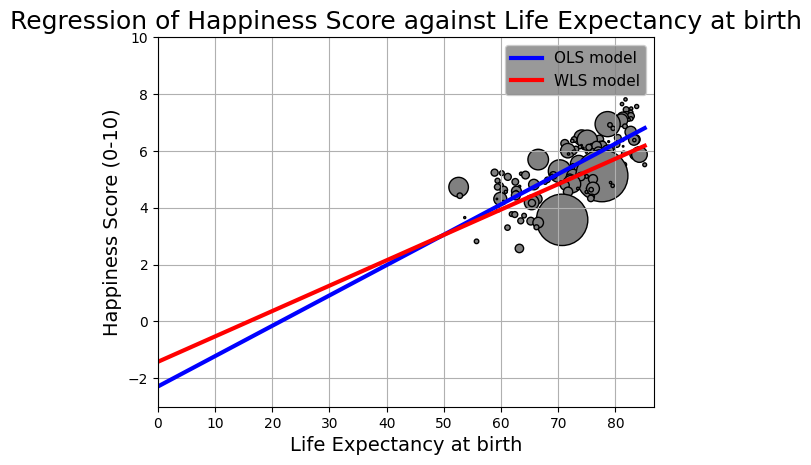

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Prepare Happiness Score, Life Expectancy with Country Population Weighting
happiness_score_2020_test = np.array(df_main_renewed['happiness_score'])
le_2020_mean_test = np.array(df_main_renewed['le_2020_mean'])
population_2020_mean_test = np.array(df_main_renewed['population_2020_mean'])
df_country_weight_test = df_country_weight['country_weight']

# Prepare the dataframe for testing
w_hs_le = pd.DataFrame({"Life Expectancy": le_2020_mean_test, "Happiness Score": happiness_score_2020_test, "Mean of Country Population (2017-2019)": population_2020_mean_test, "Weighting of Country": df_country_weight_test})

# Split the data into input features (x) and target variable (y)
x = w_hs_le[['Life Expectancy']]
y = w_hs_le['Happiness Score']
s_p = w_hs_le['Mean of Country Population (2017-2019)']
w = w_hs_le['Weighting of Country']

plt.scatter(x, y, s=s_p/1000000, edgecolor='black', color='grey')

# Generate a Ordinary Least Squares (OLS) regression model
linear_model = LinearRegression()
linear_model.fit(x, y)

# Generate a Weighted Least Squares (WLS) model
weighted_model = LinearRegression()
weighted_model.fit(x, y, w)

# Set the graph to show zero at both x-axis and y-axis
plt.xlim(left=0)
plt.ylim(-3, 10)

# Extend the range of x for plotting the regression lines
x_range = np.linspace(0, x['Life Expectancy'].max(), 100).reshape(-1, 1)

# Plot the unweighted model
plt.plot(x_range, linear_model.predict(x_range), color='blue', linewidth=3, label='OLS model')

# Plot the weighted model
plt.plot(x_range, weighted_model.predict(x_range), color='red', linewidth=3, label='WLS model')

plt.grid()

plt.xlabel('Life Expectancy at birth', fontsize=14)
plt.ylabel('Happiness Score (0-10)', fontsize=14)
plt.legend(facecolor='grey', fontsize=11)

plt.title('Regression of Happiness Score against Life Expectancy at birth', fontsize=18)

plt.show()

Regression of Life Expectancy at birth against Social Support Score

C:\Users\plkcl\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

C:\Users\plkcl\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



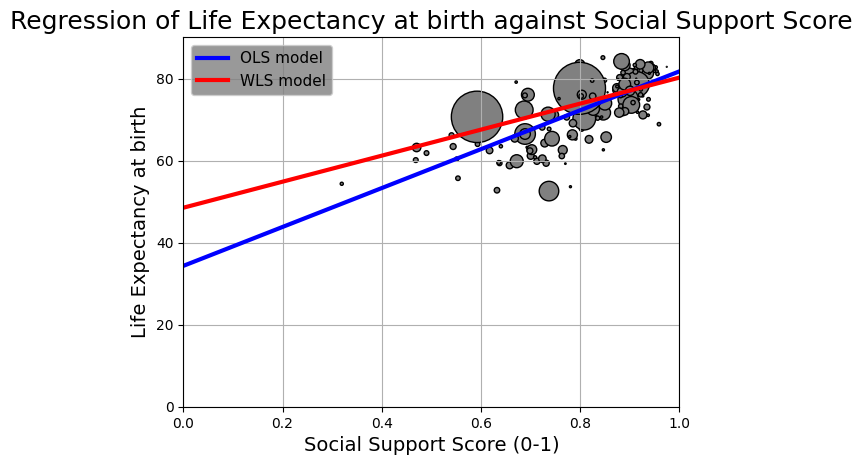

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

#Prepare Life Expectancy against Social Support Score with Country Population Weighting
social_support_test = np.array(df_main_renewed['social_support'])
le_2020_mean_test = np.array(df_main_renewed['le_2020_mean'])
population_2020_mean_test = np.array(df_main_renewed['population_2020_mean'])
df_country_weight_test = df_country_weight['country_weight']

#Prepare the dataframe for testing
w_hs_le = pd.DataFrame({"Social Support": social_support_test, "Life Expectancy": le_2020_mean_test, "Mean of Country Population (2017-2019)": population_2020_mean_test, "Weighting of Country": df_country_weight_test})

#Split the data into input features (x) and target variable (y)
x = w_hs_le[['Social Support']]
y = w_hs_le['Life Expectancy']
s_p = w_hs_le['Mean of Country Population (2017-2019)']
w = w_hs_le['Weighting of Country']

plt.scatter(x, y, s=s_p/1000000, edgecolor='black', color='grey')

#Generate a Ordinary Least Squares (OLS) regression model
linear_model = LinearRegression()
linear_model.fit(x, y)

#Generate a Weighted Least Squares (WLS) model
weighted_model = LinearRegression()
weighted_model.fit(x, y, w)

#Set the graph to show zero at both x-axis and y-axis
plt.xlim(0, 1)
plt.ylim(0, y.max() + 5)

#Extend the range of x for plotting the regression lines
x_range = np.linspace(0, 1, 100).reshape(-1, 1)

#Plot the unweighted model
plt.plot(x_range, linear_model.predict(x_range), color='blue', linewidth=3, label='OLS model')

#Plot the weighted model
plt.plot(x_range, weighted_model.predict(x_range), color='red', linewidth=3, label='WLS model')

plt.grid()

plt.xlabel('Social Support Score (0-1)', fontsize=14)
plt.ylabel('Life Expectancy at birth', fontsize=14)
plt.legend(facecolor='grey', fontsize=11)

plt.title('Regression of Life Expectancy at birth against Social Support Score', fontsize=18)

plt.show()

In [53]:
#Get data x: Social Support Score, y: Life Expectancy at birth
X = social_support_test
y = le_2020_mean_test

#Fit OLS regression model
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

#Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     165.9
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           4.40e-26
Time:                        14:36:21   Log-Likelihood:                -477.29
No. Observations:                 153   AIC:                             958.6
Df Residuals:                     151   BIC:                             964.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.3520      3.011     11.409      0.0

In [54]:
#Get data x: Social Support Score, y: Life Expectancy at birth
X = social_support_test
y = le_2020_mean_test

#Fit WLS regression model
X = sm.add_constant(X)
model = sm.WLS(y, X, weights=w)
results = model.fit()

#Print regression results
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.310
Model:                            WLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     67.84
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           7.81e-14
Time:                        14:36:21   Log-Likelihood:                -579.59
No. Observations:                 153   AIC:                             1163.
Df Residuals:                     151   BIC:                             1169.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.5334      2.987     16.247      0.0

In [55]:
fig = px.choropleth(df_main_renewed, 
                    locations="country", 
                    locationmode="country names",
                    color="freedom_to_make_life_choices",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.haline,
                    title="Freedom to make life choices by Countries").update_layout(title_x=0.5,coloraxis_colorbar=dict(title="Freedom to make life choices"))

fig.show()

Weighted Meam Freedom to make life choices Score by Country Income Groups

C:\Users\plkcl\AppData\Local\Temp\ipykernel_30872\3250134182.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



<Figure size 640x480 with 0 Axes>

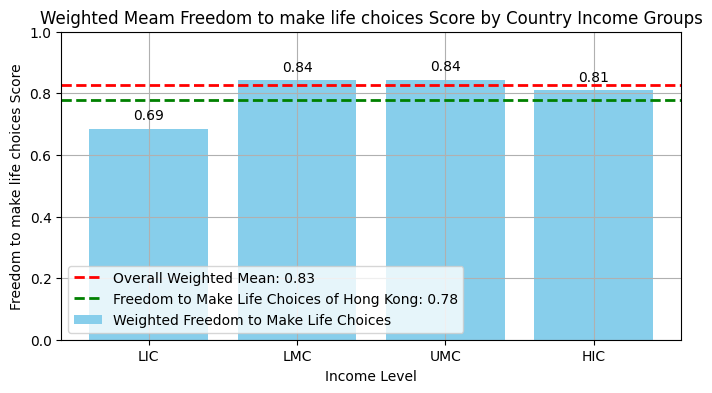

In [56]:
#Calculate weighted freedom to make life choices by income level
weighted_freedom = df_main_renewed.groupby('income_level').apply(
    lambda x: (x['freedom_to_make_life_choices'] * x['population_2020_mean']).sum() / x['population_2020_mean'].sum())

#Calculate the overall freedom to make life choices score
overall_weighted_freedom = w_freedom_to_make_life_choices.mean

#Extract freedom to make life choices score of Hong Kong
hong_kong_freedom = df_main_renewed[df_main_renewed['country'] == 'Hong Kong S.A.R. of China']['freedom_to_make_life_choices'].mean()

#List income groups' freedom to make life choices score by specific order
income_levels = ['LIC', 'LMC', 'UMC', 'HIC']
weighted_freedom = weighted_freedom.reindex(income_levels)

#Clear the current figure
plt.clf()

#Plot the graph
plt.figure(figsize=(8, 4))  # Adjusted figure size
bars = plt.bar(weighted_freedom.index, weighted_freedom, color='skyblue', label='Weighted Freedom to Make Life Choices')

#Paste bar-top labels to the graph
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

#Add horizontal lines for overall and Hong Kong freedom to make life choices scores
plt.axhline(overall_weighted_freedom, color='red', linestyle='--', linewidth=2, label=f'Overall Weighted Mean: {overall_weighted_freedom:.2f}')
plt.axhline(hong_kong_freedom, color='green', linestyle='--', linewidth=2, label=f'Freedom to Make Life Choices of Hong Kong: {hong_kong_freedom:.2f}')

#Add labels and title
plt.xlabel('Income Level')
plt.ylabel('Freedom to make life choices Score')
plt.title('Weighted Meam Freedom to make life choices Score by Country Income Groups')
plt.xticks(rotation=0)
plt.ylim(0, 1)

#Add legend and grid
plt.legend()
plt.grid()

#Show the plot
plt.show()

Correlation of Happinss Score against Freedom to make life choices

In [57]:
#Prepare mean of Happiness Score against Freedom to make life choices Score without Country Population Weighting
happiness_score_2020_test = np.array(df_main_renewed['happiness_score'])
freedom_to_make_life_choices_test = np.array(df_main_renewed['freedom_to_make_life_choices'])
population_2020_mean_test = np.array(df_main_renewed['population_2020_mean'])
df_country_weight_test = df_country_weight['country_weight']

fig = df_main_renewed.plot.scatter(x="freedom_to_make_life_choices", y="happiness_score", trendline="ols", hover_data = "country", title="Freedom to make life choices Score / Happiness Score").update_layout(xaxis_title="Freedom to make life choices Score (0-1)", yaxis_title="Ladder (Happiness) Score (0-10)"
)
fig.show()

Regression of Happiness Score against Freedom to make life choices Score

In [58]:
#Get data x: Freedom to make life choices Score, y: Happiness Score
X = freedom_to_make_life_choices_test
y = happiness_score_2020_test

#Fit OLS regression model
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

#Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     80.88
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           9.34e-16
Time:                        14:36:21   Log-Likelihood:                -200.06
No. Observations:                 153   AIC:                             404.1
Df Residuals:                     151   BIC:                             410.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1044      0.491      2.248      0.0

In [59]:
#Get data x: Freedom to make life choices Score, y: Happiness Score
X = freedom_to_make_life_choices_test
y = happiness_score_2020_test

#Fit WLS regression model
X = sm.add_constant(X)
model = sm.WLS(y, X, weights=w)
results = model.fit()

#Print regression results
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            WLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6313
Date:                Wed, 28 Aug 2024   Prob (F-statistic):              0.428
Time:                        14:36:21   Log-Likelihood:                -331.16
No. Observations:                 153   AIC:                             666.3
Df Residuals:                     151   BIC:                             672.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4817      0.762      5.880      0.0

C:\Users\plkcl\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

C:\Users\plkcl\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



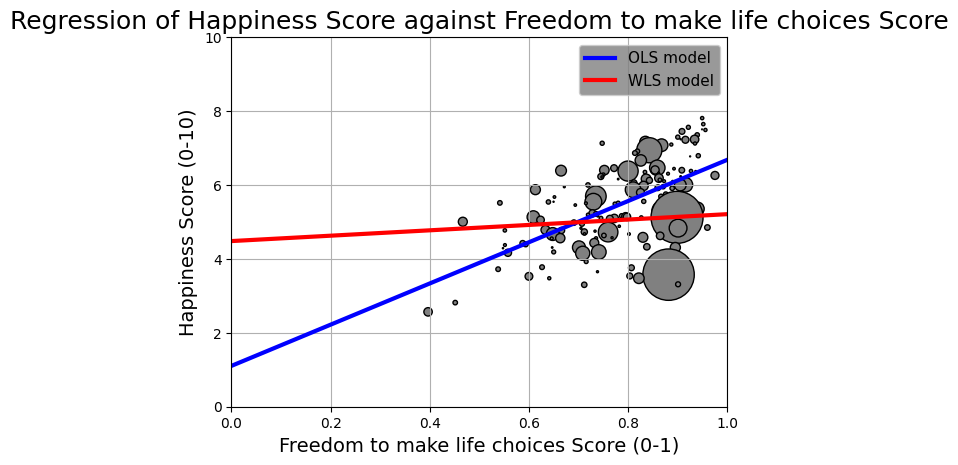

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Prepare Happiness Score, Freedom to make life choices with Country Population Weighting
happiness_score_2020_test = np.array(df_main_renewed['happiness_score'])
freedom_to_make_life_choices_test = np.array(df_main_renewed['freedom_to_make_life_choices'])
population_2020_mean_test = np.array(df_main_renewed['population_2020_mean'])
df_country_weight_test = df_country_weight['country_weight']

# Prepare the dataframe for testing
w_hs_le = pd.DataFrame({"Freedom to make life choices": freedom_to_make_life_choices_test, "Happiness Score": happiness_score_2020_test, "Mean of Country Population (2017-2019)": population_2020_mean_test, "Weighting of Country": df_country_weight_test})

# Split the data into input features (x) and target variable (y)
x = w_hs_le[['Freedom to make life choices']]
y = w_hs_le['Happiness Score']
s_p = w_hs_le['Mean of Country Population (2017-2019)']
w = w_hs_le['Weighting of Country']

plt.scatter(x, y, s=s_p/1000000, edgecolor='black', color='grey')

# Generate a Ordinary Least Squares (OLS) regression model
linear_model = LinearRegression()
linear_model.fit(x, y)

# Generate a Weighted Least Squares (WLS) model
weighted_model = LinearRegression()
weighted_model.fit(x, y, w)

# Set the graph to show zero at both x-axis and y-axis
plt.xlim(0, 1)
plt.ylim(0, 10)

# Extend the range of x for plotting the regression lines
x_range = np.linspace(0, 1, 100).reshape(-1, 1)

# Plot the unweighted model
plt.plot(x_range, linear_model.predict(x_range), color='blue', linewidth=3, label='OLS model')

# Plot the weighted model
plt.plot(x_range, weighted_model.predict(x_range), color='red', linewidth=3, label='WLS model')

plt.grid()

plt.xlabel('Freedom to make life choices Score (0-1)', fontsize=14)
plt.ylabel('Happiness Score (0-10)', fontsize=14)
plt.legend(facecolor='grey', fontsize=11)

plt.title('Regression of Happiness Score against Freedom to make life choices Score', fontsize=18)

plt.show()

Perceptions of Corruption

In [61]:
fig = px.choropleth(df_main_renewed, 
                    locations="country", 
                    locationmode="country names",
                    color="perceptions_of_corruption",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.Greys,
                    title="Perceptions of Corruption (0-1)").update_layout(title_x=0.5,coloraxis_colorbar=dict(title="Perceptions of Corruption"))

fig.show()

Weighted Mean Perceptions of Corruption Score by Country Income Groups

C:\Users\plkcl\AppData\Local\Temp\ipykernel_30872\3847448896.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



<Figure size 640x480 with 0 Axes>

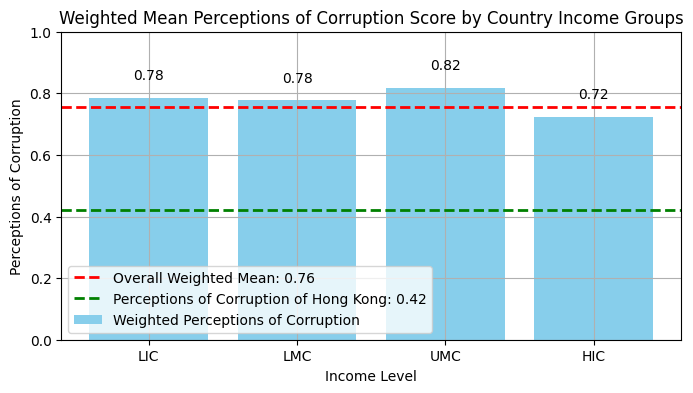

In [62]:
#Calculate weighted perceptions of corruption by income level
weighted_corruption = df_main_renewed.groupby('income_level').apply(
    lambda x: (x['perceptions_of_corruption'] * x['perceptions_of_corruption']).sum() / x['perceptions_of_corruption'].sum()
)

#Calculate the overall perceptions of corruption score
overall_weighted_corruption = w_perceptions_of_corruption.mean

#Extract perceptions of corruption score of Hong Kong
hong_kong_corruption = df_main_renewed[df_main_renewed['country'] == 'Hong Kong S.A.R. of China']['perceptions_of_corruption'].mean()

#List income groups' perceptions of corruption score by specific order
income_levels = ['LIC', 'LMC', 'UMC', 'HIC']
weighted_corruption = weighted_corruption.reindex(income_levels)

#Clear the current figure
plt.clf()

#Plot the graph
plt.figure(figsize=(8, 4))  # Adjusted figure size
bars = plt.bar(weighted_corruption.index, weighted_corruption, color='skyblue', label='Weighted Perceptions of Corruption')

#Paste bar-top labels to the graph
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.2f}', ha='center', va='bottom')

#Add horizontal lines for overall and Hong Kong perceptions of corruption scores
plt.axhline(overall_weighted_corruption, color='red', linestyle='--', linewidth=2, label=f'Overall Weighted Mean: {overall_weighted_corruption:.2f}')
plt.axhline(hong_kong_corruption, color='green', linestyle='--', linewidth=2, label=f'Perceptions of Corruption of Hong Kong: {hong_kong_corruption:.2f}')

#Add labels and title
plt.xlabel('Income Level')
plt.ylabel('Perceptions of Corruption')
plt.title('Weighted Mean Perceptions of Corruption Score by Country Income Groups')
plt.xticks(rotation=0)
plt.ylim(0, 1)

#Add legend and grid
plt.legend()
plt.grid()

#Show the plot
plt.show()

Correlation of Happinss Score against Perception of Corruption Score

In [63]:
#Prepare mean of Happiness Score against Perception of corruption Score without Country Population Weighting
happiness_score_2020_test = np.array(df_main_renewed['happiness_score'])
perceptions_of_corruption_test = np.array(df_main_renewed['perceptions_of_corruption'])
population_2020_mean_test = np.array(df_main_renewed['population_2020_mean'])
df_country_weight_test = df_country_weight['country_weight']

fig = df_main_renewed.plot.scatter(x="perceptions_of_corruption", y="happiness_score", trendline="ols", hover_data = "country", title="Perception of corruption Score / Happiness Score").update_layout(xaxis_title="Perception of corruption Score (0-1)", yaxis_title="Ladder (Happiness) Score (0-10)"
)

fig.show()

Regression of Happiness Score against Perception of Corruption Score

In [64]:
#Get data x: Perception of corruption Score, y: Happiness Score
X = perceptions_of_corruption_test
y = happiness_score_2020_test

#Fit OLS regression model
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

#Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     32.03
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           7.43e-08
Time:                        14:36:22   Log-Likelihood:                -218.16
No. Observations:                 153   AIC:                             440.3
Df Residuals:                     151   BIC:                             446.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4205      0.354     20.979      0.0

In [65]:
#Get data x: Perception of corruption Score, y: Happiness Score
X = perceptions_of_corruption_test
y = happiness_score_2020_test

#Fit WLS regression model
X = sm.add_constant(X)
model = sm.WLS(y, X, weights=w)
results = model.fit()

#Print regression results
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.116
Model:                            WLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     19.78
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           1.68e-05
Time:                        14:36:22   Log-Likelihood:                -322.06
No. Observations:                 153   AIC:                             648.1
Df Residuals:                     151   BIC:                             654.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8072      0.618     12.631      0.0

C:\Users\plkcl\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

C:\Users\plkcl\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



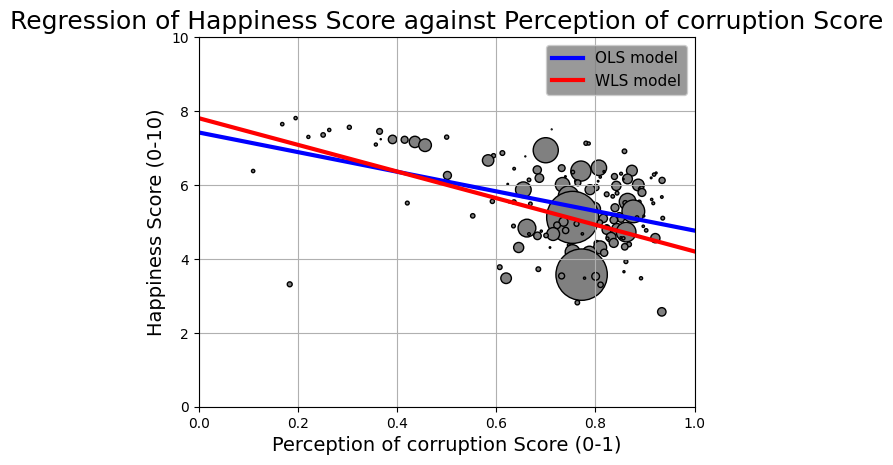

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Prepare Happiness Score, Perception of corruption Score with Country Population Weighting
happiness_score_2020_test = np.array(df_main_renewed['happiness_score'])
perceptions_of_corruption_test = np.array(df_main_renewed['perceptions_of_corruption'])
population_2020_mean_test = np.array(df_main_renewed['population_2020_mean'])
df_country_weight_test = df_country_weight['country_weight']

# Prepare the dataframe for testing
w_hs_le = pd.DataFrame({"Perception of corruption Score": perceptions_of_corruption_test, "Happiness Score": happiness_score_2020_test, "Mean of Country Population (2017-2019)": population_2020_mean_test, "Weighting of Country": df_country_weight_test})

# Split the data into input features (x) and target variable (y)
x = w_hs_le[['Perception of corruption Score']]
y = w_hs_le['Happiness Score']
s_p = w_hs_le['Mean of Country Population (2017-2019)']
w = w_hs_le['Weighting of Country']

plt.scatter(x, y, s=s_p/1000000, edgecolor='black', color='grey')

# Generate a Ordinary Least Squares (OLS) regression model
linear_model = LinearRegression()
linear_model.fit(x, y)

# Generate a Weighted Least Squares (WLS) model
weighted_model = LinearRegression()
weighted_model.fit(x, y, w)

# Set the graph to show zero at both x-axis and y-axis
plt.xlim(0, 1)
plt.ylim(0, 10)

# Extend the range of x for plotting the regression lines
x_range = np.linspace(0, 1, 100).reshape(-1, 1)

# Plot the unweighted model
plt.plot(x_range, linear_model.predict(x_range), color='blue', linewidth=3, label='OLS model')

# Plot the weighted model
plt.plot(x_range, weighted_model.predict(x_range), color='red', linewidth=3, label='WLS model')

plt.grid()
plt.xlabel('Perception of corruption Score (0-1)', fontsize=14)
plt.ylabel('Happiness Score (0-10)', fontsize=14)
plt.legend(facecolor='grey', fontsize=11)
plt.title('Regression of Happiness Score against Perception of corruption Score', fontsize=18)
plt.show()

Generosity

In [67]:
fig = px.choropleth(df_main_renewed, 
                    locations="country", 
                    locationmode="country names",
                    color="generosity",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.ice,
                    title="Generosity").update_layout(title_x=0.5,coloraxis_colorbar=dict(title="Generosity"))

fig.show()

Correlation of Happinss Score against Generosity Score

In [68]:
#Prepare mean of Happiness Score against Generosity Score without Country Population Weighting
happiness_score_2020_test = np.array(df_main_renewed['happiness_score'])
generosity_test = np.array(df_main_renewed['generosity'])
population_2020_mean_test = np.array(df_main_renewed['population_2020_mean'])
df_country_weight_test = df_country_weight['country_weight']

fig = df_main_renewed.plot.scatter(x="generosity", y="happiness_score", trendline="ols", hover_data = "country", title="Generosity Score / Happiness Score").update_layout(xaxis_title="Generosity Score (0-1)", yaxis_title="Ladder (Happiness) Score (0-10)"
)

fig.show()

Weighted Mean Generosity Score by Country Income Groups

C:\Users\plkcl\AppData\Local\Temp\ipykernel_30872\2836374280.py:8: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



<Figure size 640x480 with 0 Axes>

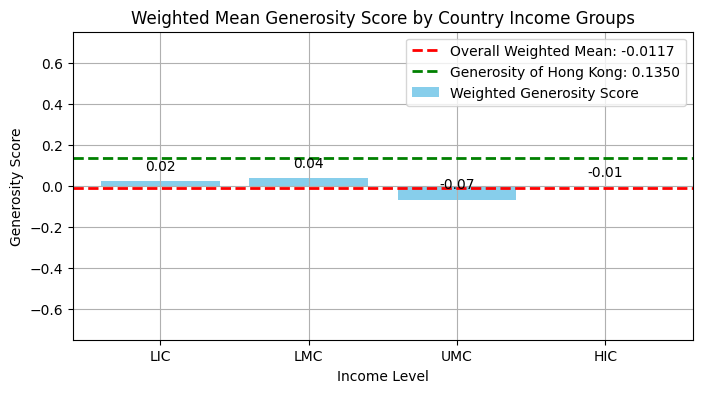

In [69]:
#Calculate weighted generosity by income level
def group_generosity(x):
    geneosity_group_weight = sum(x['country_weight'])
    generosity_weighted_sum = sum(x['generosity'] * x['country_weight'])
    gernerosity_by_group = generosity_weighted_sum / geneosity_group_weight
    return(gernerosity_by_group)

weighted_generosity = df_main_renewed.groupby('income_level').apply(
    lambda x_x: group_generosity(x_x)
)

#Calculate the overall generosity score
overall_weighted_generosity = w_generosity.mean

#Extract generosity score of Hong Kong
hong_kong_generosity = df_main_renewed[df_main_renewed['country'] == 'Hong Kong S.A.R. of China']['generosity'].mean()

#List income groups' generosity score by specific order
income_levels = ['LIC', 'LMC', 'UMC', 'HIC']
weighted_generosity = weighted_generosity.reindex(income_levels)

#Clear the current figure
plt.clf()

#Plot the graph
plt.figure(figsize=(8, 4))
bars = plt.bar(weighted_generosity.index, weighted_generosity, color='skyblue', label='Weighted Generosity Score')

#Paste bar-top labels to the graph
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.04, f'{yval:.2f}', ha='center', va='bottom')

#Add horizontal lines for overall and Hong Kong generosity scores
plt.axhline(overall_weighted_generosity, color='red', linestyle='--', linewidth=2, label=f'Overall Weighted Mean: {overall_weighted_generosity:.4f}')
plt.axhline(hong_kong_generosity, color='green', linestyle='--', linewidth=2, label=f'Generosity of Hong Kong: {hong_kong_generosity:.4f}')

#Add labels and title
plt.xlabel('Income Level')
plt.ylabel('Generosity Score')
plt.title('Weighted Mean Generosity Score by Country Income Groups')
plt.xticks(rotation=0)
plt.ylim(-0.75, 0.75)

#Add legend and grid
plt.legend()
plt.grid()

#Show the plot
plt.show()

Regression of Happiness Score against Generosity Score

C:\Users\plkcl\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

C:\Users\plkcl\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



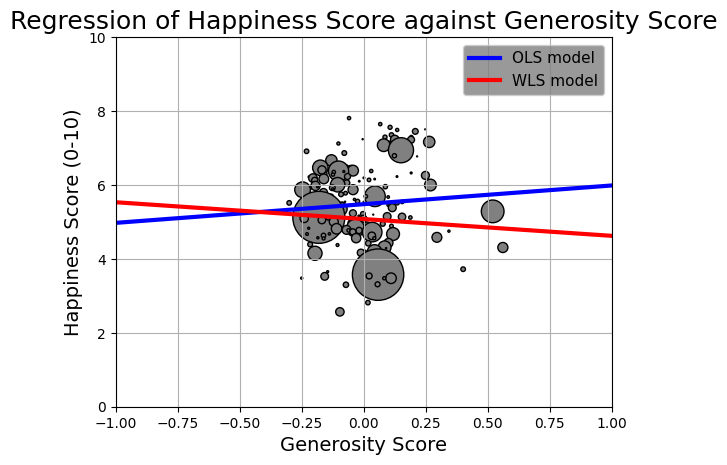

In [70]:
#Prepare Happiness Score, Generosity Score with Country Population Weighting
happiness_score_2020_test = np.array(df_main_renewed['happiness_score'])
generosity_test = np.array(df_main_renewed['generosity'])
population_2020_mean_test = np.array(df_main_renewed['population_2020_mean'])
df_country_weight_test = df_country_weight['country_weight']

#Prepare the dataframe for testing
w_hs_le = pd.DataFrame({"Generosity Score": generosity_test, "Happiness Score": happiness_score_2020_test, "Mean of Country Population (2017-2019)": population_2020_mean_test, "Weighting of Country": df_country_weight_test})

#Split the data into input features (x) and target variable (y)
x = w_hs_le[['Generosity Score']]
y = w_hs_le['Happiness Score']
s_p = w_hs_le['Mean of Country Population (2017-2019)']
w = w_hs_le['Weighting of Country']

plt.scatter(x, y, s=s_p/1000000, edgecolor='black', color='grey')

#Generate a Ordinary Least Squares (OLS) regression model
linear_model = LinearRegression()
linear_model.fit(x, y)

#Generate a Weighted Least Squares (WLS) model
weighted_model = LinearRegression()
weighted_model.fit(x, y, sample_weight=w)

#Set the graph to show zero at both x-axis and y-axis
plt.xlim(-1, 1)
plt.ylim(0, 10)

#Plot the unweighted model
regr_l = LinearRegression()
regr_l.fit(x, y)
x_range = np.linspace(-1, 1, 100).reshape(-1, 1)
plt.plot(x_range, regr_l.predict(x_range), color='blue', linewidth=3, label='OLS model')

#Plot the weighted model
regr_w = LinearRegression()
regr_w.fit(x, y, sample_weight=w)
plt.plot(x_range, regr_w.predict(x_range), color='red', linewidth=3, label='WLS model')

plt.grid()
plt.xlabel('Generosity Score', fontsize=14)
plt.ylabel('Happiness Score (0-10)', fontsize=14)
plt.legend(facecolor='grey', fontsize=11)
plt.title('Regression of Happiness Score against Generosity Score', fontsize=18)
plt.show()

In [71]:
#Get data x: Generosity Score, y: Happiness Score
X = generosity_test
y = happiness_score_2020_test

#Fit OLS regression model
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

#Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7233
Date:                Wed, 28 Aug 2024   Prob (F-statistic):              0.396
Time:                        14:36:22   Log-Likelihood:                -232.51
No. Observations:                 153   AIC:                             469.0
Df Residuals:                     151   BIC:                             475.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4806      0.090     60.613      0.0

In [72]:
#Get data x: Generosity Score, y: Happiness Score
X = generosity_test
y = happiness_score_2020_test

#Fit WLS regression model
X = sm.add_constant(X)
model = sm.WLS(y, X, weights=w)
results = model.fit()

#Print regression results
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7910
Date:                Wed, 28 Aug 2024   Prob (F-statistic):              0.375
Time:                        14:36:22   Log-Likelihood:                -331.08
No. Observations:                 153   AIC:                             666.2
Df Residuals:                     151   BIC:                             672.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0780      0.088     57.627      0.0

Refine the linear regression model without considering country weights

In [73]:
# defining the target variable vs other features that contribute
independ_var = df_main_renewed
depend_var = df_main_renewed['happiness_score']

In [74]:
# dropping irrelevant features
independ_var = independ_var.drop('happiness_score', axis = 1)
independ_var = independ_var.drop('country_code', axis = 1)
independ_var = independ_var.drop('country', axis = 1)
independ_var = independ_var.drop('region', axis = 1)
independ_var = independ_var.drop('income_level', axis = 1)
independ_var = independ_var.drop('population_2020_mean', axis = 1)
independ_var = independ_var.drop('gdp_2020_mean', axis = 1)
independ_var = independ_var.drop('country_weight', axis = 1)

In [75]:
x_train, x_test, y_train, y_test = train_test_split(independ_var, depend_var, test_size=0.25, train_size=0.75, random_state=None)

ols_regress = LinearRegression()

ols_regress.fit(x_train, y_train)

y_pred = ols_regress.predict(x_test)

r2_trained = r2_score(y_test, y_pred)
print("In the testing, the proportion of variance (R^2) of tested Happiness Scores explained by the independent variables in the model: ", r2_trained)

print("")
ols_regress_coef = ols_regress.coef_
ols_regress_intercept = ols_regress.intercept_

print("The correlation coefficient of the unmodified OLS Model: ", ols_regress_coef)
print("The y-intercept of the unmodified OLS Model: ", ols_regress_intercept)
print("")

print(independ_var.columns)
print("")

weighted_happiness = df_main_renewed.groupby('income_level').apply(
    lambda x: (x['happiness_score'] * x['population_2020_mean']).sum() / x['population_2020_mean'].sum())

mse = mean_squared_error(y_test, y_pred)
print("The Mean Squared Error (MSE) of the model: ", mse)
print("")

print("For the unmodified model:")
print(f"Happiness Score = Log(GDP per capita*){ols_regress_coef[0]} + Life Expectancy/8{ols_regress_coef[1]} + Social Support*{ols_regress_coef[2]}+")
print(f"Freedom to make life choices*{ols_regress_coef[3]} + Generosity*{ols_regress_coef[4]} - Perception of corruption*{ols_regress_coef[5]} + ({ols_regress_intercept}) (constant)")
print("")

print("While Hong Kong is not in further analysis, its statistics in 2021 are available for model testing:")
print("")
print("Log(GDP per capita (2018-2020) = 4.67823239713")
print("Mean of Life Expectancy at birth (2018-2020) = 85.2033333333")
print("Social Support = 0.836")
print("Freedom to make life choices = 0.717")
print("Generosity = 0.067")
print("Perception of corruption = 0.403")
print("")

e_happiness_score_hkg = 4.67823239713*ols_regress_coef[0] + 85.2033333333*ols_regress_coef[1] + 0.836*ols_regress_coef[2] + 0.717*ols_regress_coef[3] + 0.067*ols_regress_coef[4] - 0.403*ols_regress_coef[5] + ols_regress_intercept
print("The estimated Happiness Score of Hong Kong (2021): ", e_happiness_score_hkg)
print("The surveyed Happiness Score of Hong Kong (2021): 5.477")
print("The difference in score ", e_happiness_score_hkg - 5.477)
print("")
print("which shows more data (especially the country population weighting) for model training is needed.")

In the testing, the proportion of variance (R^2) of tested Happiness Scores explained by the independent variables in the model:  0.7454127326161459

The correlation coefficient of the unmodified OLS Model:  [ 0.3333474   0.0108846   2.89262624  1.70333033  0.19520618 -0.3048785 ]
The y-intercept of the unmodified OLS Model:  -1.659382625763043

Index(['gdp_2020_log', 'le_2020_mean', 'social_support',
       'freedom_to_make_life_choices', 'generosity',
       'perceptions_of_corruption'],
      dtype='object')

The Mean Squared Error (MSE) of the model:  0.33086840207096785

For the unmodified model:
Happiness Score = Log(GDP per capita*)0.33334740217201314 + Life Expectancy/80.010884597389757417 + Social Support*2.8926262437502093+
Freedom to make life choices*1.7033303307011782 + Generosity*0.1952061799156366 - Perception of corruption*-0.30487850286801726 + (-1.659382625763043) (constant)

While Hong Kong is not in further analysis, its statistics in 2021 are available for model te

C:\Users\plkcl\AppData\Local\Temp\ipykernel_30872\1054633219.py:23: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Text(0, 0.5, 'Happiness Score')

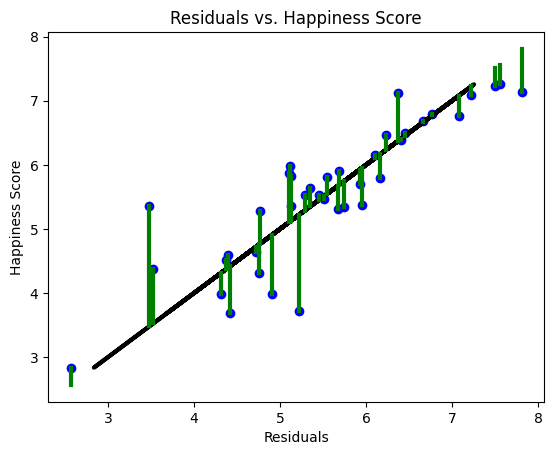

In [76]:
#Plot the residuals with the linear regression to see if they are in normality

plt.scatter(y_test,y_pred, color='blue')
plt.plot(y_pred,y_pred, color='black', linewidth=3)

# draw vertical lines frome each data point to its predict value
[plt.plot([x,x],[yp,yt], color='green', linewidth=3) for x, yp, yt in zip(y_test, y_pred, y_test)]

plt.title('Residuals vs. Happiness Score')
plt.xlabel('Residuals')
plt.ylabel('Happiness Score')     

In [77]:
# defining the target variable vs other features that contribute
independ_var_2 = df_main_renewed
depend_var_2 = df_main_renewed['happiness_score']

In [78]:
# dropping irrelevant features
independ_var_2 = independ_var_2.drop('happiness_score', axis = 1)
independ_var_2 = independ_var_2.drop('country_code', axis = 1)
independ_var_2 = independ_var_2.drop('country', axis = 1)
independ_var_2 = independ_var_2.drop('region', axis = 1)
independ_var_2 = independ_var_2.drop('income_level', axis = 1)
independ_var_2 = independ_var_2.drop('population_2020_mean', axis = 1)
independ_var_2 = independ_var_2.drop('gdp_2020_mean', axis = 1)
independ_var_2 = independ_var_2.drop('freedom_to_make_life_choices', axis = 1)
independ_var_2 = independ_var_2.drop('generosity', axis = 1)
independ_var_2 = independ_var_2.drop('country_weight', axis = 1)

In [79]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(independ_var_2, depend_var_2, test_size=0.25, train_size=0.75, random_state=None)

ols_regress_2 = LinearRegression()

ols_regress_2.fit(x_train_2, y_train_2)

y_pred_2 = ols_regress_2.predict(x_test_2)

r2_trained_2 = r2_score(y_test_2, y_pred_2)

print("In the testing, the proportion of variance (R^2) of tested Happiness Scores explained by the independent variables in the model: ", r2_trained_2)
print("")

OLS_regress_2_coef = ols_regress_2.coef_
OLS_regress_2_intercept = ols_regress_2.intercept_

print("The correlation coefficient of the modified OLS Model: ", OLS_regress_2_coef)
print("The y-intercept of the modified OLS Model: ", OLS_regress_2_intercept)
print("")

print(independ_var_2.columns)
print("")

mse = mean_squared_error(y_test,y_pred)
print("The Mean Squared Error (MSE) of the model: ", mse)
print("")

print("For the modified model:")
print(f"Happiness Score = Log(GDP per capita)*{OLS_regress_2_coef[0]} + Life Expectancy*{OLS_regress_2_coef[1]} + Social Support*{OLS_regress_2_coef[2]} - ")
print(f"Perception of corruption*{OLS_regress_2_coef[3]} + ({OLS_regress_2_intercept}) (constant)")
print("")

print("The model is to be tested with Hong Kong's happiness score (2021) for model testing:")
print("")

print("Log(GDP per capita (2018-2020) = 4.67823239713")
print("Mean of Life Expectancy at birth (2018-2020) = 85.2033333333")
print("Social Support = 0.836")
print("Perception of corruption = 0.403")
print("")

e_happiness_score_hkg_2 = 4.67823239713*OLS_regress_2_coef[0] + 85.2033333333*OLS_regress_2_coef[1] + 0.836*OLS_regress_2_coef[2] - 0.403*OLS_regress_2_coef[3] + OLS_regress_2_intercept
print("The estimated Happiness Score of Hong Kong (2021): ", e_happiness_score_hkg_2)
print("The surveyed Happiness Score of Hong Kong (2021): 5.477")
print("The difference in score ", e_happiness_score_hkg_2-5.477)
print("")
print("which shows without the country population weighting, dropping Generosity Score and Perception of corruption Score would constitute a better model for estimation.")

In the testing, the proportion of variance (R^2) of tested Happiness Scores explained by the independent variables in the model:  0.5291828381517715

The correlation coefficient of the modified OLS Model:  [ 0.283685    0.01072931  4.51518789 -0.77421785]
The y-intercept of the modified OLS Model:  -0.8884160043185876

Index(['gdp_2020_log', 'le_2020_mean', 'social_support',
       'perceptions_of_corruption'],
      dtype='object')

The Mean Squared Error (MSE) of the model:  0.33086840207096785

For the modified model:
Happiness Score = Log(GDP per capita)*0.283684998539534 + Life Expectancy*0.010729313364088472 + Social Support*4.515187890473754 - 
Perception of corruption*-0.7742178504923477 + (-0.8884160043185876) (constant)

The model is to be tested with Hong Kong's happiness score (2021) for model testing:

Log(GDP per capita (2018-2020) = 4.67823239713
Mean of Life Expectancy at birth (2018-2020) = 85.2033333333
Social Support = 0.836
Perception of corruption = 0.403

The esti

Text(0, 0.5, 'Happiness Score')

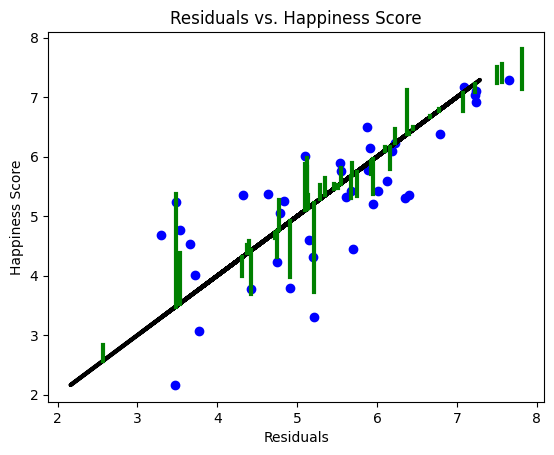

In [80]:
#Plot the residuals with the linear regression to see if they are in normality

plt.scatter(y_test_2,y_pred_2, color='blue')
plt.plot(y_pred_2,y_pred_2, color='black', linewidth=3)

# draw vertical lines frome each data point to its predict value
[plt.plot([x,x],[yp,yt], color='green', linewidth=3) for x, yp, yt in zip(y_test, y_pred, y_test)]

plt.title('Residuals vs. Happiness Score')
plt.xlabel('Residuals')
plt.ylabel('Happiness Score')     

A Dropdown Menu of Hong Kong's happiness-related data

In [81]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

data = {
    'Happiness': [overall_weighted_happiness, hong_kong_happiness],
    'Population':[overall_world_population, hong_kong_population],
    'GDP': [overall_weighted_gdp, hong_kong_gdp],
    'Life Expectancy': [overall_weighted_le, hong_kong_le],
    'Social Support': [overall_weighted_social_support, hong_kong_social_support],
    'Freedom': [overall_weighted_freedom, hong_kong_freedom],
    'Generosity': [overall_weighted_generosity, hong_kong_generosity],
    'Corruption': [overall_weighted_corruption, hong_kong_corruption]
}

options = list(data.keys())
dropdown = widgets.Dropdown(options=options, description='Select the table:')

def plot_bar_chart(option):
    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Overall', 'Hong Kong'], data[option], color=['blue', 'orange'])
    plt.xlabel('Category')
    plt.ylabel('Values')
    plt.title(f'{option}')
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
    
    plt.show()

output = widgets.interactive_output(plot_bar_chart, {'option': dropdown})

display(dropdown, output)

Dropdown(description='Select the table:', options=('Happiness', 'Population', 'GDP', 'Life Expectancy', 'Socia…

Output()